In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

# On Mac you may encounter an error related to OMP, this is a workaround, but slows down the code
# https://github.com/dmlc/xgboost/issues/1715
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ['CUDA_HOME'] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.3"
os.environ['CUDA_VERSION'] = "11.3"

In [2]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.9.3'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
if tf.test.gpu_device_name():
    print("Default GPU Device:{}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF if you have one.")

Default GPU Device:/device:GPU:0


In [5]:
from openbot import dataloader, data_augmentation, utils, train

Default GPU Device:/device:GPU:0


## Set train and test dirs

Define the dataset directory and give it a name. Inside the dataset folder, there should be two folders, `train_data` and `test_data`. 

In [6]:
dataset_dir = "dataset"
dataset_name = "openbot"
train_data_dir = os.path.join(dataset_dir, "train_data")
test_data_dir = os.path.join(dataset_dir, "test_data")

## Hyperparameters
<a id='hyperparameters'></a>

You may have to tune the learning rate and batch size depending on your available compute resources and dataset. As a general rule of thumb, if you increase the batch size by a factor of n, you can increase the learning rate by a factor of sqrt(n). In order to accelerate training and make it more smooth, you should increase the batch size as much as possible. In our paper we used a batch size of 128. For debugging and hyperparamter tuning, you can set the number of epochs to a small value like 10. If you want to train a model which will achieve good performance, you should set it to 50 or more. In our paper we used 100.

In [7]:
params = train.Hyperparameters()

params.MODEL = "pilot_reinforcement"  # choices: "pilot_net","cil_mobile","cil_mobile_fast","cil", "pilot_reinforcement"
params.POLICY = "autopilot"  # choices: "autopilot","point_goal_nav"
params.TRAIN_BATCH_SIZE = 128
params.TEST_BATCH_SIZE = 16
params.LEARNING_RATE = 0.0003
params.NUM_EPOCHS = 100
params.BATCH_NORM = True  # use batch norm (recommended)
params.FLIP_AUG = False  # flip image and controls as augmentation (only autopilot)
params.CMD_AUG = False  # randomize high-level command as augmentation (only autopilot)
params.USE_LAST = False  # resume training from last checkpoint
params.WANDB = False
# policy = "autopilot": images are expected to be 256x96 - no cropping required
# policy = "point_goal_nav": images are expected to be 160x120 - cropping to 160x90
params.IS_CROP = params.POLICY == "point_goal_nav"

## Pre-process the dataset

In [8]:
tr = train.Training(params)
tr.dataset_name = dataset_name
tr.train_data_dir = train_data_dir
tr.test_data_dir = test_data_dir

Running this for the first time will take some time. This code will match image frames to the controls (labels) and indicator signals (commands).  By default, data samples where the vehicle was stationary will be removed. If this is not desired, you need to set `tr.remove_zeros = False`. If you have made any changes to the sensor files, changed `remove_zeros` or moved your dataset to a new directory, you need to set `tr.redo_matching = True`. 

In [9]:
tr.redo_matching = True
tr.remove_zeros = True
train.process_data(tr)

Train Datasets:  1
Test Datasets:  1
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
There are 5397 train images and 1716 test images
STARTING REWARD SESSION
Processing folder dataset\train_data\dataset_control\20231211_160235
 Frames and rewards matched.
 Preprocessing completed.
STARTING REWARD SESSION
Processing folder dataset\train_data\dataset_control\20231211_160514
 Frames and rewards matched.
 Preprocessing completed.
STARTING REWARD SESSION
Processing folder dataset\train_data\dataset_control\20231211_160937
 Frames and rewards matched.
 Preprocessing completed.
ST

In [10]:
import threading


def broadcast(event, payload=None):
    print(event, payload)


event = threading.Event()
my_callback = train.MyCallback(broadcast, event)

In the next step, you can convert your dataset to a tfrecord, a data format optimized for training. You can skip this step if you already created a tfrecord before or if you want to train using the files directly. 

In [11]:
train.create_tfrecord(my_callback, policy=tr.hyperparameters.POLICY)

message Converting data to tfrecord (this may take some time)...
Reading dataset from c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\train_data
TFRecord will be saved at c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\tfrecords/train.tfrec
Number of Datasets Available:  1
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
reward_file c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\train_data\dataset_control\20231211_160235\reward_data\matched_frame_reward_processed.txt
reward_file c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\train_data\dataset_control\20231211_160514\reward_data\matched_frame_reward_processed.txt
reward_file c:\Users\lilou\Documen

## Load the dataset

If you did not create a tfrecord and want to load and buffer files from disk directly, set `no_tf_record = True`.

In [12]:
no_tf_record = False

In [13]:
if no_tf_record:
    tr.train_data_dir = train_data_dir
    tr.test_data_dir = test_data_dir
    train.load_data(tr, verbose=3)
else:
    tr.train_data_dir = os.path.join(dataset_dir, "tfrecords/train.tfrec")
    tr.test_data_dir = os.path.join(dataset_dir, "tfrecords/test.tfrec")
    train.load_tfrecord(tr, verbose=0)

Image shape:  (96, 256, 3)
Command:  0.0
Label:  [0.27058825 0.27058825]
Reward:  0.0
Number of training instances:  5383
Number of test instances:  1712


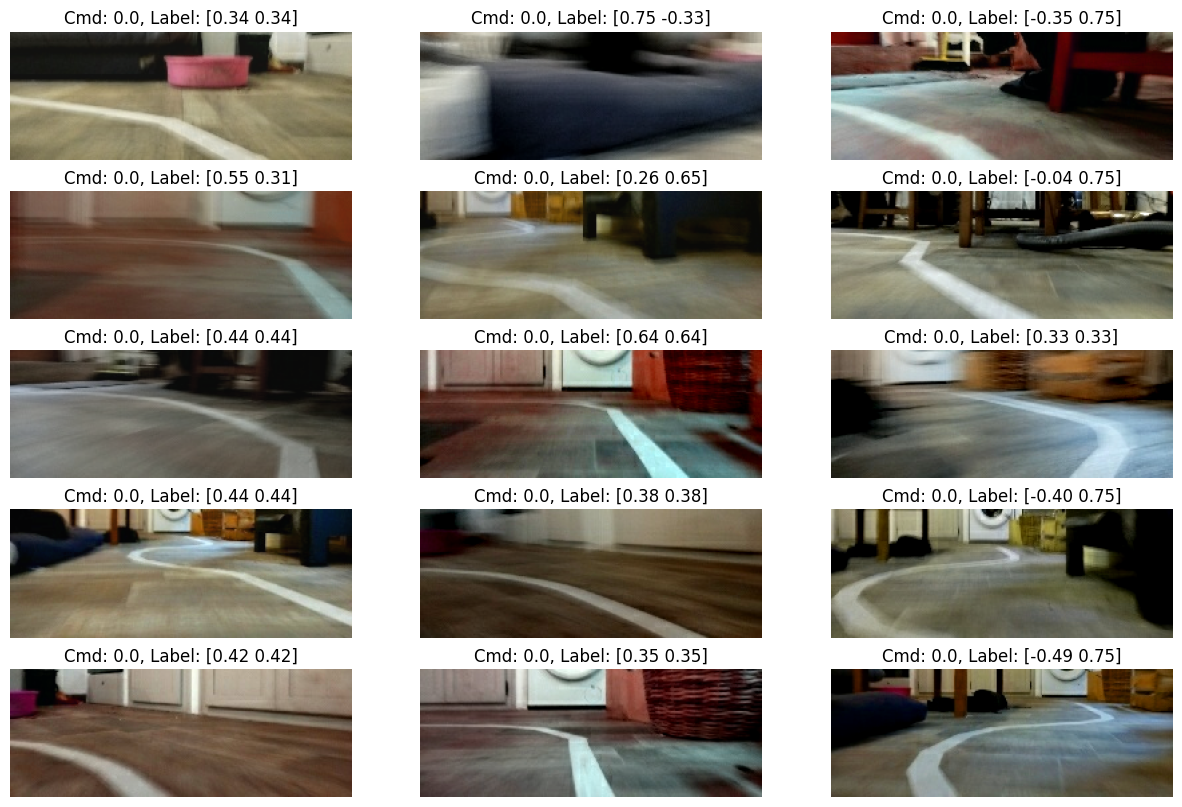

In [14]:
%matplotlib inline
utils.show_batch(dataset=tr.train_ds, policy=tr.hyperparameters.POLICY, model=None)

## Training

The number of epochs is proportional to the training time. One epoch means going through the complete dataset once. Increasing `NUM_EPOCHS` will mean longer training time, but generally leads to better performance. To get familiar with the code it can be set to small values like `5` or `10`. To train a model that performs well, it should be set to values between `50` and `200`. Setting `USE_LAST` to `true` will resume the training from the last checkpoint. The default values are `NUM_EPOCHS = 100` and `USE_LAST = False`. They are set in [Hyperparameters](#hyperparameters).

In [15]:
# params.NUM_EPOCHS = 200
# params.USE_LAST = True

train.do_training(tr, my_callback, verbose=1)

model openbot_pilot_reinforcement_lr0.0003_bz128_bn
Model: "pilot_reinforcement"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 96, 256, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 46, 126, 24)  1824        ['img_input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 46, 126, 24)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                            

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.2620500326156616, 'mean_absolute_error': 0.4468790590763092, 'direction_metric': 0.4189680218696594, 'angle_metric': 0.14607557654380798, 'val_loss': -0.1931336671113968, 'val_mean_absolute_error': 0.34590205550193787, 'val_direction_metric': 0.9871495366096497, 'val_angle_metric': 0.6915887594223022, 'epoch': 0}
logs {'loss': 0.2620500326156616, 'mean_absolute_error': 0.4468790590763092, 'direction_metric': 0.4189680218696594, 'angle_metric': 0.14607557654380798, 'val_loss': -0.1931336671113968, 'val_mean_absolute_error': 0.34590205550193787, 'val_direction_metric': 0.9871495366096497, 'val_angle_metric': 0.6915887594223022, 'epoch': 0}
43/43 [==============================] - 17s 224ms/step - loss: 0.2621 - mean_absolute_error: 0.4469 - direction_metric: 0.4190 - angle_metric: 0.1461 - val_loss: -0.1931 - val_mean_absolute_error: 0.3459 - val_direction_metric: 0.9871 - val_angle_metric: 0.6916
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': -0.15190815925598145, 'mean_absolute_error': 0.284479558467865, 'direction_metric': 0.4936409890651703, 'angle_metric': 0.18332122266292572, 'val_loss': -0.22925347089767456, 'val_mean_absolute_error': 0.2828168272972107, 'val_direction_metric': 0.8966121673583984, 'val_angle_metric': 0.6028037667274475, 'epoch': 1}
logs {'loss': -0.15190815925598145, 'mean_absolute_error': 0.284479558467865, 'direction_metric': 0.4936409890651703, 'angle_metric': 0.18332122266292572, 'val_loss': -0.22925347089767456, 'val_mean_absolute_error': 0.2828168272972107, 'val_direction_metric': 0.8966121673583984, 'val_angle_metric': 0.6028037667274475, 'epoch': 1}
43/43 [==============================] - 8s 192ms/step - loss: -0.1519 - mean_absolute_error: 0.2845 - direction_metric: 0.4936 - angle_metric: 0.1833 - val_loss: -0.2293 - val_mean_absolute_error: 0.2828 - val_direction_metric: 0.8966 - val_angle_metric: 0.6028
Epoch 3/100
43/43 [==============================] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.2118425965309143, 'mean_absolute_error': 0.24393539130687714, 'direction_metric': 0.5130813717842102, 'angle_metric': 0.19622093439102173, 'val_loss': -0.16904494166374207, 'val_mean_absolute_error': 0.24867141246795654, 'val_direction_metric': 0.2307243049144745, 'val_angle_metric': 0.02862149477005005, 'epoch': 2}
logs {'loss': -0.2118425965309143, 'mean_absolute_error': 0.24393539130687714, 'direction_metric': 0.5130813717842102, 'angle_metric': 0.19622093439102173, 'val_loss': -0.16904494166374207, 'val_mean_absolute_error': 0.24867141246795654, 'val_direction_metric': 0.2307243049144745, 'val_angle_metric': 0.02862149477005005, 'epoch': 2}
43/43 [==============================] - 6s 139ms/step - loss: -0.2118 - mean_absolute_error: 0.2439 - direction_metric: 0.5131 - angle_metric: 0.1962 - val_loss: -0.1690 - val_mean_absolute_error: 0.2487 - val_direction_metric: 0.2307 - val_angle_metric: 0.0286
Epoch 4/100
43/43 [==============================] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.2724466323852539, 'mean_absolute_error': 0.21970711648464203, 'direction_metric': 0.5292514562606812, 'angle_metric': 0.21384447813034058, 'val_loss': -0.22214606404304504, 'val_mean_absolute_error': 0.19389215111732483, 'val_direction_metric': 0.548481285572052, 'val_angle_metric': 0.33060747385025024, 'epoch': 3}
logs {'loss': -0.2724466323852539, 'mean_absolute_error': 0.21970711648464203, 'direction_metric': 0.5292514562606812, 'angle_metric': 0.21384447813034058, 'val_loss': -0.22214606404304504, 'val_mean_absolute_error': 0.19389215111732483, 'val_direction_metric': 0.548481285572052, 'val_angle_metric': 0.33060747385025024, 'epoch': 3}
43/43 [==============================] - 6s 142ms/step - loss: -0.2724 - mean_absolute_error: 0.2197 - direction_metric: 0.5293 - angle_metric: 0.2138 - val_loss: -0.2221 - val_mean_absolute_error: 0.1939 - val_direction_metric: 0.5485 - val_angle_metric: 0.3306
Epoch 5/100
42/43 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.25999483466148376, 'mean_absolute_error': 0.2030661553144455, 'direction_metric': 0.547420084476471, 'angle_metric': 0.22565406560897827, 'val_loss': -0.03220301866531372, 'val_mean_absolute_error': 0.2886292338371277, 'val_direction_metric': 0.2307243049144745, 'val_angle_metric': 0.028037382289767265, 'epoch': 4}
logs {'loss': -0.25999483466148376, 'mean_absolute_error': 0.2030661553144455, 'direction_metric': 0.547420084476471, 'angle_metric': 0.22565406560897827, 'val_loss': -0.03220301866531372, 'val_mean_absolute_error': 0.2886292338371277, 'val_direction_metric': 0.2307243049144745, 'val_angle_metric': 0.028037382289767265, 'epoch': 4}
43/43 [==============================] - 4s 93ms/step - loss: -0.2600 - mean_absolute_error: 0.2031 - direction_metric: 0.5474 - angle_metric: 0.2257 - val_loss: -0.0322 - val_mean_absolute_error: 0.2886 - val_direction_metric: 0.2307 - val_angle_metric: 0.0280
Epoch 6/100
42/43 [============================>.] - ETA: 0s -

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': -0.3121732771396637, 'mean_absolute_error': 0.1889764815568924, 'direction_metric': 0.561954915523529, 'angle_metric': 0.25199854373931885, 'val_loss': -0.30009081959724426, 'val_mean_absolute_error': 0.17084045708179474, 'val_direction_metric': 0.6308411359786987, 'val_angle_metric': 0.36565420031547546, 'epoch': 5}
logs {'loss': -0.3121732771396637, 'mean_absolute_error': 0.1889764815568924, 'direction_metric': 0.561954915523529, 'angle_metric': 0.25199854373931885, 'val_loss': -0.30009081959724426, 'val_mean_absolute_error': 0.17084045708179474, 'val_direction_metric': 0.6308411359786987, 'val_angle_metric': 0.36565420031547546, 'epoch': 5}
43/43 [==============================] - 8s 189ms/step - loss: -0.3122 - mean_absolute_error: 0.1890 - direction_metric: 0.5620 - angle_metric: 0.2520 - val_loss: -0.3001 - val_mean_absolute_error: 0.1708 - val_direction_metric: 0.6308 - val_angle_metric: 0.3657
Epoch 7/100
42/43 [============================>.] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.33331000804901123, 'mean_absolute_error': 0.17535029351711273, 'direction_metric': 0.5790334343910217, 'angle_metric': 0.26871365308761597, 'val_loss': -0.2875698208808899, 'val_mean_absolute_error': 0.18636363744735718, 'val_direction_metric': 0.46612149477005005, 'val_angle_metric': 0.22021028399467468, 'epoch': 6}
logs {'loss': -0.33331000804901123, 'mean_absolute_error': 0.17535029351711273, 'direction_metric': 0.5790334343910217, 'angle_metric': 0.26871365308761597, 'val_loss': -0.2875698208808899, 'val_mean_absolute_error': 0.18636363744735718, 'val_direction_metric': 0.46612149477005005, 'val_angle_metric': 0.22021028399467468, 'epoch': 6}
43/43 [==============================] - 6s 143ms/step - loss: -0.3333 - mean_absolute_error: 0.1754 - direction_metric: 0.5790 - angle_metric: 0.2687 - val_loss: -0.2876 - val_mean_absolute_error: 0.1864 - val_direction_metric: 0.4661 - val_angle_metric: 0.2202
Epoch 8/100
43/43 [==============================] - ETA:

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.34414806962013245, 'mean_absolute_error': 0.16736838221549988, 'direction_metric': 0.5928415656089783, 'angle_metric': 0.2952398359775543, 'val_loss': -0.2927471995353699, 'val_mean_absolute_error': 0.18019500374794006, 'val_direction_metric': 0.4877336323261261, 'val_angle_metric': 0.23306074738502502, 'epoch': 7}
logs {'loss': -0.34414806962013245, 'mean_absolute_error': 0.16736838221549988, 'direction_metric': 0.5928415656089783, 'angle_metric': 0.2952398359775543, 'val_loss': -0.2927471995353699, 'val_mean_absolute_error': 0.18019500374794006, 'val_direction_metric': 0.4877336323261261, 'val_angle_metric': 0.23306074738502502, 'epoch': 7}
43/43 [==============================] - 6s 138ms/step - loss: -0.3441 - mean_absolute_error: 0.1674 - direction_metric: 0.5928 - angle_metric: 0.2952 - val_loss: -0.2927 - val_mean_absolute_error: 0.1802 - val_direction_metric: 0.4877 - val_angle_metric: 0.2331
Epoch 9/100
42/43 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.36850011348724365, 'mean_absolute_error': 0.155625581741333, 'direction_metric': 0.5993822813034058, 'angle_metric': 0.3112281858921051, 'val_loss': -0.2930290102958679, 'val_mean_absolute_error': 0.18648457527160645, 'val_direction_metric': 0.523948609828949, 'val_angle_metric': 0.27336448431015015, 'epoch': 8}
logs {'loss': -0.36850011348724365, 'mean_absolute_error': 0.155625581741333, 'direction_metric': 0.5993822813034058, 'angle_metric': 0.3112281858921051, 'val_loss': -0.2930290102958679, 'val_mean_absolute_error': 0.18648457527160645, 'val_direction_metric': 0.523948609828949, 'val_angle_metric': 0.27336448431015015, 'epoch': 8}
43/43 [==============================] - 6s 140ms/step - loss: -0.3685 - mean_absolute_error: 0.1556 - direction_metric: 0.5994 - angle_metric: 0.3112 - val_loss: -0.2930 - val_mean_absolute_error: 0.1865 - val_direction_metric: 0.5239 - val_angle_metric: 0.2734
Epoch 10/100
42/43 [============================>.] - ETA: 0s - los

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': -0.36720502376556396, 'mean_absolute_error': 0.15247878432273865, 'direction_metric': 0.6122819781303406, 'angle_metric': 0.3310319781303406, 'val_loss': -0.31330907344818115, 'val_mean_absolute_error': 0.1742030829191208, 'val_direction_metric': 0.5163551568984985, 'val_angle_metric': 0.26460281014442444, 'epoch': 9}
logs {'loss': -0.36720502376556396, 'mean_absolute_error': 0.15247878432273865, 'direction_metric': 0.6122819781303406, 'angle_metric': 0.3310319781303406, 'val_loss': -0.31330907344818115, 'val_mean_absolute_error': 0.1742030829191208, 'val_direction_metric': 0.5163551568984985, 'val_angle_metric': 0.26460281014442444, 'epoch': 9}
43/43 [==============================] - 6s 139ms/step - loss: -0.3672 - mean_absolute_error: 0.1525 - direction_metric: 0.6123 - angle_metric: 0.3310 - val_loss: -0.3133 - val_mean_absolute_error: 0.1742 - val_direction_metric: 0.5164 - val_angle_metric: 0.2646
Epoch 11/100
43/43 [==============================] - ETA: 0s

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': -0.3927130103111267, 'mean_absolute_error': 0.14441189169883728, 'direction_metric': 0.641170084476471, 'angle_metric': 0.36282703280448914, 'val_loss': -0.3223462700843811, 'val_mean_absolute_error': 0.1718827337026596, 'val_direction_metric': 0.5134345889091492, 'val_angle_metric': 0.2552570104598999, 'epoch': 10}
logs {'loss': -0.3927130103111267, 'mean_absolute_error': 0.14441189169883728, 'direction_metric': 0.641170084476471, 'angle_metric': 0.36282703280448914, 'val_loss': -0.3223462700843811, 'val_mean_absolute_error': 0.1718827337026596, 'val_direction_metric': 0.5134345889091492, 'val_angle_metric': 0.2552570104598999, 'epoch': 10}
43/43 [==============================] - 8s 187ms/step - loss: -0.3927 - mean_absolute_error: 0.1444 - direction_metric: 0.6412 - angle_metric: 0.3628 - val_loss: -0.3223 - val_mean_absolute_error: 0.1719 - val_direction_metric: 0.5134 - val_angle_metric: 0.2553
Epoch 12/100
43/43 [==============================] - ETA: 0s - l

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.4052029550075531, 'mean_absolute_error': 0.13698314130306244, 'direction_metric': 0.6506177186965942, 'angle_metric': 0.38462936878204346, 'val_loss': -0.3037462532520294, 'val_mean_absolute_error': 0.17534619569778442, 'val_direction_metric': 0.5245327353477478, 'val_angle_metric': 0.2815420627593994, 'epoch': 11}
logs {'loss': -0.4052029550075531, 'mean_absolute_error': 0.13698314130306244, 'direction_metric': 0.6506177186965942, 'angle_metric': 0.38462936878204346, 'val_loss': -0.3037462532520294, 'val_mean_absolute_error': 0.17534619569778442, 'val_direction_metric': 0.5245327353477478, 'val_angle_metric': 0.2815420627593994, 'epoch': 11}
43/43 [==============================] - 6s 134ms/step - loss: -0.4052 - mean_absolute_error: 0.1370 - direction_metric: 0.6506 - angle_metric: 0.3846 - val_loss: -0.3037 - val_mean_absolute_error: 0.1753 - val_direction_metric: 0.5245 - val_angle_metric: 0.2815
Epoch 13/100
43/43 [==============================] - ETA: 0s

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.41203781962394714, 'mean_absolute_error': 0.13288912177085876, 'direction_metric': 0.6544331312179565, 'angle_metric': 0.39643895626068115, 'val_loss': -0.3107706308364868, 'val_mean_absolute_error': 0.17952294647693634, 'val_direction_metric': 0.5116822719573975, 'val_angle_metric': 0.2535046637058258, 'epoch': 12}
logs {'loss': -0.41203781962394714, 'mean_absolute_error': 0.13288912177085876, 'direction_metric': 0.6544331312179565, 'angle_metric': 0.39643895626068115, 'val_loss': -0.3107706308364868, 'val_mean_absolute_error': 0.17952294647693634, 'val_direction_metric': 0.5116822719573975, 'val_angle_metric': 0.2535046637058258, 'epoch': 12}
43/43 [==============================] - 6s 136ms/step - loss: -0.4120 - mean_absolute_error: 0.1329 - direction_metric: 0.6544 - angle_metric: 0.3964 - val_loss: -0.3108 - val_mean_absolute_error: 0.1795 - val_direction_metric: 0.5117 - val_angle_metric: 0.2535
Epoch 14/100
42/43 [============================>.] - ETA: 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.4141506850719452, 'mean_absolute_error': 0.12719959020614624, 'direction_metric': 0.6744186282157898, 'angle_metric': 0.4129723906517029, 'val_loss': -0.30443117022514343, 'val_mean_absolute_error': 0.1794842630624771, 'val_direction_metric': 0.5157710313796997, 'val_angle_metric': 0.2686915993690491, 'epoch': 13}
logs {'loss': -0.4141506850719452, 'mean_absolute_error': 0.12719959020614624, 'direction_metric': 0.6744186282157898, 'angle_metric': 0.4129723906517029, 'val_loss': -0.30443117022514343, 'val_mean_absolute_error': 0.1794842630624771, 'val_direction_metric': 0.5157710313796997, 'val_angle_metric': 0.2686915993690491, 'epoch': 13}
43/43 [==============================] - 6s 136ms/step - loss: -0.4142 - mean_absolute_error: 0.1272 - direction_metric: 0.6744 - angle_metric: 0.4130 - val_loss: -0.3044 - val_mean_absolute_error: 0.1795 - val_direction_metric: 0.5158 - val_angle_metric: 0.2687
Epoch 15/100
42/43 [============================>.] - ETA: 0s -

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.41333046555519104, 'mean_absolute_error': 0.12302255630493164, 'direction_metric': 0.6809592843055725, 'angle_metric': 0.4345930218696594, 'val_loss': -0.3033037483692169, 'val_mean_absolute_error': 0.17982184886932373, 'val_direction_metric': 0.5315420627593994, 'val_angle_metric': 0.2815420627593994, 'epoch': 14}
logs {'loss': -0.41333046555519104, 'mean_absolute_error': 0.12302255630493164, 'direction_metric': 0.6809592843055725, 'angle_metric': 0.4345930218696594, 'val_loss': -0.3033037483692169, 'val_mean_absolute_error': 0.17982184886932373, 'val_direction_metric': 0.5315420627593994, 'val_angle_metric': 0.2815420627593994, 'epoch': 14}
43/43 [==============================] - 4s 90ms/step - loss: -0.4133 - mean_absolute_error: 0.1230 - direction_metric: 0.6810 - angle_metric: 0.4346 - val_loss: -0.3033 - val_mean_absolute_error: 0.1798 - val_direction_metric: 0.5315 - val_angle_metric: 0.2815
Epoch 16/100
42/43 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.42848044633865356, 'mean_absolute_error': 0.11672437936067581, 'direction_metric': 0.6967659592628479, 'angle_metric': 0.45875728130340576, 'val_loss': -0.29436835646629333, 'val_mean_absolute_error': 0.18598344922065735, 'val_direction_metric': 0.483060747385025, 'val_angle_metric': 0.23481307923793793, 'epoch': 15}
logs {'loss': -0.42848044633865356, 'mean_absolute_error': 0.11672437936067581, 'direction_metric': 0.6967659592628479, 'angle_metric': 0.45875728130340576, 'val_loss': -0.29436835646629333, 'val_mean_absolute_error': 0.18598344922065735, 'val_direction_metric': 0.483060747385025, 'val_angle_metric': 0.23481307923793793, 'epoch': 15}
43/43 [==============================] - 6s 137ms/step - loss: -0.4285 - mean_absolute_error: 0.1167 - direction_metric: 0.6968 - angle_metric: 0.4588 - val_loss: -0.2944 - val_mean_absolute_error: 0.1860 - val_direction_metric: 0.4831 - val_angle_metric: 0.2348
Epoch 17/100
43/43 [==============================] - ETA

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.43963757157325745, 'mean_absolute_error': 0.11312507838010788, 'direction_metric': 0.7073037624359131, 'angle_metric': 0.46820494532585144, 'val_loss': -0.3004835247993469, 'val_mean_absolute_error': 0.18058748543262482, 'val_direction_metric': 0.5221962332725525, 'val_angle_metric': 0.2757009267807007, 'epoch': 16}
logs {'loss': -0.43963757157325745, 'mean_absolute_error': 0.11312507838010788, 'direction_metric': 0.7073037624359131, 'angle_metric': 0.46820494532585144, 'val_loss': -0.3004835247993469, 'val_mean_absolute_error': 0.18058748543262482, 'val_direction_metric': 0.5221962332725525, 'val_angle_metric': 0.2757009267807007, 'epoch': 16}
43/43 [==============================] - 6s 140ms/step - loss: -0.4396 - mean_absolute_error: 0.1131 - direction_metric: 0.7073 - angle_metric: 0.4682 - val_loss: -0.3005 - val_mean_absolute_error: 0.1806 - val_direction_metric: 0.5222 - val_angle_metric: 0.2757
Epoch 18/100
42/43 [============================>.] - ETA: 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4194214940071106, 'mean_absolute_error': 0.10840323567390442, 'direction_metric': 0.7229287624359131, 'angle_metric': 0.4938226640224457, 'val_loss': -0.29878735542297363, 'val_mean_absolute_error': 0.18281710147857666, 'val_direction_metric': 0.5093457698822021, 'val_angle_metric': 0.25584113597869873, 'epoch': 17}
logs {'loss': -0.4194214940071106, 'mean_absolute_error': 0.10840323567390442, 'direction_metric': 0.7229287624359131, 'angle_metric': 0.4938226640224457, 'val_loss': -0.29878735542297363, 'val_mean_absolute_error': 0.18281710147857666, 'val_direction_metric': 0.5093457698822021, 'val_angle_metric': 0.25584113597869873, 'epoch': 17}
43/43 [==============================] - 4s 87ms/step - loss: -0.4194 - mean_absolute_error: 0.1084 - direction_metric: 0.7229 - angle_metric: 0.4938 - val_loss: -0.2988 - val_mean_absolute_error: 0.1828 - val_direction_metric: 0.5093 - val_angle_metric: 0.2558
Epoch 19/100
42/43 [============================>.] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.45021411776542664, 'mean_absolute_error': 0.10232659429311752, 'direction_metric': 0.7291061282157898, 'angle_metric': 0.5076308250427246, 'val_loss': -0.30469217896461487, 'val_mean_absolute_error': 0.18107351660728455, 'val_direction_metric': 0.4964953362941742, 'val_angle_metric': 0.24240654706954956, 'epoch': 18}
logs {'loss': -0.45021411776542664, 'mean_absolute_error': 0.10232659429311752, 'direction_metric': 0.7291061282157898, 'angle_metric': 0.5076308250427246, 'val_loss': -0.30469217896461487, 'val_mean_absolute_error': 0.18107351660728455, 'val_direction_metric': 0.4964953362941742, 'val_angle_metric': 0.24240654706954956, 'epoch': 18}
43/43 [==============================] - 6s 138ms/step - loss: -0.4502 - mean_absolute_error: 0.1023 - direction_metric: 0.7291 - angle_metric: 0.5076 - val_loss: -0.3047 - val_mean_absolute_error: 0.1811 - val_direction_metric: 0.4965 - val_angle_metric: 0.2424
Epoch 20/100
43/43 [==============================] - ETA

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4430665373802185, 'mean_absolute_error': 0.09828688204288483, 'direction_metric': 0.7485465407371521, 'angle_metric': 0.5361555218696594, 'val_loss': -0.2861193120479584, 'val_mean_absolute_error': 0.18674921989440918, 'val_direction_metric': 0.5070093274116516, 'val_angle_metric': 0.25759345293045044, 'epoch': 19}
logs {'loss': -0.4430665373802185, 'mean_absolute_error': 0.09828688204288483, 'direction_metric': 0.7485465407371521, 'angle_metric': 0.5361555218696594, 'val_loss': -0.2861193120479584, 'val_mean_absolute_error': 0.18674921989440918, 'val_direction_metric': 0.5070093274116516, 'val_angle_metric': 0.25759345293045044, 'epoch': 19}
43/43 [==============================] - 4s 87ms/step - loss: -0.4431 - mean_absolute_error: 0.0983 - direction_metric: 0.7485 - angle_metric: 0.5362 - val_loss: -0.2861 - val_mean_absolute_error: 0.1867 - val_direction_metric: 0.5070 - val_angle_metric: 0.2576
Epoch 21/100
42/43 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.4619223177433014, 'mean_absolute_error': 0.09456604719161987, 'direction_metric': 0.7521802186965942, 'angle_metric': 0.5403342843055725, 'val_loss': -0.30427980422973633, 'val_mean_absolute_error': 0.17700788378715515, 'val_direction_metric': 0.5292056202888489, 'val_angle_metric': 0.2815420627593994, 'epoch': 20}
logs {'loss': -0.4619223177433014, 'mean_absolute_error': 0.09456604719161987, 'direction_metric': 0.7521802186965942, 'angle_metric': 0.5403342843055725, 'val_loss': -0.30427980422973633, 'val_mean_absolute_error': 0.17700788378715515, 'val_direction_metric': 0.5292056202888489, 'val_angle_metric': 0.2815420627593994, 'epoch': 20}
43/43 [==============================] - 6s 138ms/step - loss: -0.4619 - mean_absolute_error: 0.0946 - direction_metric: 0.7522 - angle_metric: 0.5403 - val_loss: -0.3043 - val_mean_absolute_error: 0.1770 - val_direction_metric: 0.5292 - val_angle_metric: 0.2815
Epoch 22/100
42/43 [============================>.] - ETA: 0s

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4465348422527313, 'mean_absolute_error': 0.0930594876408577, 'direction_metric': 0.7570857405662537, 'angle_metric': 0.555232584476471, 'val_loss': -0.2911728024482727, 'val_mean_absolute_error': 0.1847814917564392, 'val_direction_metric': 0.48714953660964966, 'val_angle_metric': 0.23656542599201202, 'epoch': 21}
logs {'loss': -0.4465348422527313, 'mean_absolute_error': 0.0930594876408577, 'direction_metric': 0.7570857405662537, 'angle_metric': 0.555232584476471, 'val_loss': -0.2911728024482727, 'val_mean_absolute_error': 0.1847814917564392, 'val_direction_metric': 0.48714953660964966, 'val_angle_metric': 0.23656542599201202, 'epoch': 21}
43/43 [==============================] - 4s 92ms/step - loss: -0.4465 - mean_absolute_error: 0.0931 - direction_metric: 0.7571 - angle_metric: 0.5552 - val_loss: -0.2912 - val_mean_absolute_error: 0.1848 - val_direction_metric: 0.4871 - val_angle_metric: 0.2366
Epoch 23/100
43/43 [==============================] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.46216562390327454, 'mean_absolute_error': 0.09016645699739456, 'direction_metric': 0.7636264562606812, 'angle_metric': 0.5568677186965942, 'val_loss': -0.30260610580444336, 'val_mean_absolute_error': 0.1782543659210205, 'val_direction_metric': 0.5221962332725525, 'val_angle_metric': 0.2780373692512512, 'epoch': 22}
logs {'loss': -0.46216562390327454, 'mean_absolute_error': 0.09016645699739456, 'direction_metric': 0.7636264562606812, 'angle_metric': 0.5568677186965942, 'val_loss': -0.30260610580444336, 'val_mean_absolute_error': 0.1782543659210205, 'val_direction_metric': 0.5221962332725525, 'val_angle_metric': 0.2780373692512512, 'epoch': 22}
43/43 [==============================] - 6s 134ms/step - loss: -0.4622 - mean_absolute_error: 0.0902 - direction_metric: 0.7636 - angle_metric: 0.5569 - val_loss: -0.3026 - val_mean_absolute_error: 0.1783 - val_direction_metric: 0.5222 - val_angle_metric: 0.2780
Epoch 24/100
42/43 [============================>.] - ETA: 0s

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4510030448436737, 'mean_absolute_error': 0.08720684796571732, 'direction_metric': 0.7699854373931885, 'angle_metric': 0.5755813717842102, 'val_loss': -0.30659252405166626, 'val_mean_absolute_error': 0.17630718648433685, 'val_direction_metric': 0.5391355156898499, 'val_angle_metric': 0.28738316893577576, 'epoch': 23}
logs {'loss': -0.4510030448436737, 'mean_absolute_error': 0.08720684796571732, 'direction_metric': 0.7699854373931885, 'angle_metric': 0.5755813717842102, 'val_loss': -0.30659252405166626, 'val_mean_absolute_error': 0.17630718648433685, 'val_direction_metric': 0.5391355156898499, 'val_angle_metric': 0.28738316893577576, 'epoch': 23}
43/43 [==============================] - 4s 91ms/step - loss: -0.4510 - mean_absolute_error: 0.0872 - direction_metric: 0.7700 - angle_metric: 0.5756 - val_loss: -0.3066 - val_mean_absolute_error: 0.1763 - val_direction_metric: 0.5391 - val_angle_metric: 0.2874
Epoch 25/100
43/43 [==============================] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.44043684005737305, 'mean_absolute_error': 0.0845593586564064, 'direction_metric': 0.7899709343910217, 'angle_metric': 0.590661346912384, 'val_loss': -0.31170687079429626, 'val_mean_absolute_error': 0.17430731654167175, 'val_direction_metric': 0.5578271150588989, 'val_angle_metric': 0.305490642786026, 'epoch': 24}
logs {'loss': -0.44043684005737305, 'mean_absolute_error': 0.0845593586564064, 'direction_metric': 0.7899709343910217, 'angle_metric': 0.590661346912384, 'val_loss': -0.31170687079429626, 'val_mean_absolute_error': 0.17430731654167175, 'val_direction_metric': 0.5578271150588989, 'val_angle_metric': 0.305490642786026, 'epoch': 24}
43/43 [==============================] - 4s 89ms/step - loss: -0.4404 - mean_absolute_error: 0.0846 - direction_metric: 0.7900 - angle_metric: 0.5907 - val_loss: -0.3117 - val_mean_absolute_error: 0.1743 - val_direction_metric: 0.5578 - val_angle_metric: 0.3055
Epoch 26/100
43/43 [==============================] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4553907513618469, 'mean_absolute_error': 0.08165451139211655, 'direction_metric': 0.8075944781303406, 'angle_metric': 0.629723846912384, 'val_loss': -0.3052928149700165, 'val_mean_absolute_error': 0.17753154039382935, 'val_direction_metric': 0.548481285572052, 'val_angle_metric': 0.2938084006309509, 'epoch': 25}
logs {'loss': -0.4553907513618469, 'mean_absolute_error': 0.08165451139211655, 'direction_metric': 0.8075944781303406, 'angle_metric': 0.629723846912384, 'val_loss': -0.3052928149700165, 'val_mean_absolute_error': 0.17753154039382935, 'val_direction_metric': 0.548481285572052, 'val_angle_metric': 0.2938084006309509, 'epoch': 25}
43/43 [==============================] - 4s 93ms/step - loss: -0.4554 - mean_absolute_error: 0.0817 - direction_metric: 0.8076 - angle_metric: 0.6297 - val_loss: -0.3053 - val_mean_absolute_error: 0.1775 - val_direction_metric: 0.5485 - val_angle_metric: 0.2938
Epoch 27/100
42/43 [============================>.] - ETA: 0s - loss

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.4694589078426361, 'mean_absolute_error': 0.08026711642742157, 'direction_metric': 0.8170421719551086, 'angle_metric': 0.6284520626068115, 'val_loss': -0.3058527708053589, 'val_mean_absolute_error': 0.17528007924556732, 'val_direction_metric': 0.5642523169517517, 'val_angle_metric': 0.31191587448120117, 'epoch': 26}
logs {'loss': -0.4694589078426361, 'mean_absolute_error': 0.08026711642742157, 'direction_metric': 0.8170421719551086, 'angle_metric': 0.6284520626068115, 'val_loss': -0.3058527708053589, 'val_mean_absolute_error': 0.17528007924556732, 'val_direction_metric': 0.5642523169517517, 'val_angle_metric': 0.31191587448120117, 'epoch': 26}
43/43 [==============================] - 6s 139ms/step - loss: -0.4695 - mean_absolute_error: 0.0803 - direction_metric: 0.8170 - angle_metric: 0.6285 - val_loss: -0.3059 - val_mean_absolute_error: 0.1753 - val_direction_metric: 0.5643 - val_angle_metric: 0.3119
Epoch 28/100
42/43 [============================>.] - ETA: 0s

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.46974146366119385, 'mean_absolute_error': 0.07924027740955353, 'direction_metric': 0.8175871968269348, 'angle_metric': 0.6380813717842102, 'val_loss': -0.3076089918613434, 'val_mean_absolute_error': 0.17705965042114258, 'val_direction_metric': 0.5543224215507507, 'val_angle_metric': 0.305490642786026, 'epoch': 27}
logs {'loss': -0.46974146366119385, 'mean_absolute_error': 0.07924027740955353, 'direction_metric': 0.8175871968269348, 'angle_metric': 0.6380813717842102, 'val_loss': -0.3076089918613434, 'val_mean_absolute_error': 0.17705965042114258, 'val_direction_metric': 0.5543224215507507, 'val_angle_metric': 0.305490642786026, 'epoch': 27}
43/43 [==============================] - 6s 142ms/step - loss: -0.4697 - mean_absolute_error: 0.0792 - direction_metric: 0.8176 - angle_metric: 0.6381 - val_loss: -0.3076 - val_mean_absolute_error: 0.1771 - val_direction_metric: 0.5543 - val_angle_metric: 0.3055
Epoch 29/100
43/43 [==============================] - ETA: 0s -

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4631634056568146, 'mean_absolute_error': 0.07603326439857483, 'direction_metric': 0.8244912624359131, 'angle_metric': 0.6433503031730652, 'val_loss': -0.3112982213497162, 'val_mean_absolute_error': 0.1733139455318451, 'val_direction_metric': 0.5584112405776978, 'val_angle_metric': 0.30841121077537537, 'epoch': 28}
logs {'loss': -0.4631634056568146, 'mean_absolute_error': 0.07603326439857483, 'direction_metric': 0.8244912624359131, 'angle_metric': 0.6433503031730652, 'val_loss': -0.3112982213497162, 'val_mean_absolute_error': 0.1733139455318451, 'val_direction_metric': 0.5584112405776978, 'val_angle_metric': 0.30841121077537537, 'epoch': 28}
43/43 [==============================] - 4s 88ms/step - loss: -0.4632 - mean_absolute_error: 0.0760 - direction_metric: 0.8245 - angle_metric: 0.6434 - val_loss: -0.3113 - val_mean_absolute_error: 0.1733 - val_direction_metric: 0.5584 - val_angle_metric: 0.3084
Epoch 30/100
42/43 [============================>.] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4524531662464142, 'mean_absolute_error': 0.0725119337439537, 'direction_metric': 0.8470203280448914, 'angle_metric': 0.6785973906517029, 'val_loss': -0.31346800923347473, 'val_mean_absolute_error': 0.1729181557893753, 'val_direction_metric': 0.547897219657898, 'val_angle_metric': 0.2949766218662262, 'epoch': 29}
logs {'loss': -0.4524531662464142, 'mean_absolute_error': 0.0725119337439537, 'direction_metric': 0.8470203280448914, 'angle_metric': 0.6785973906517029, 'val_loss': -0.31346800923347473, 'val_mean_absolute_error': 0.1729181557893753, 'val_direction_metric': 0.547897219657898, 'val_angle_metric': 0.2949766218662262, 'epoch': 29}
43/43 [==============================] - 4s 98ms/step - loss: -0.4525 - mean_absolute_error: 0.0725 - direction_metric: 0.8470 - angle_metric: 0.6786 - val_loss: -0.3135 - val_mean_absolute_error: 0.1729 - val_direction_metric: 0.5479 - val_angle_metric: 0.2950
Epoch 31/100
43/43 [==============================] - ETA: 0s - loss

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.45920905470848083, 'mean_absolute_error': 0.07312742620706558, 'direction_metric': 0.8370276093482971, 'angle_metric': 0.6676962375640869, 'val_loss': -0.30529364943504333, 'val_mean_absolute_error': 0.17440050840377808, 'val_direction_metric': 0.5613317489624023, 'val_angle_metric': 0.3078271150588989, 'epoch': 30}
logs {'loss': -0.45920905470848083, 'mean_absolute_error': 0.07312742620706558, 'direction_metric': 0.8370276093482971, 'angle_metric': 0.6676962375640869, 'val_loss': -0.30529364943504333, 'val_mean_absolute_error': 0.17440050840377808, 'val_direction_metric': 0.5613317489624023, 'val_angle_metric': 0.3078271150588989, 'epoch': 30}
43/43 [==============================] - 4s 89ms/step - loss: -0.4592 - mean_absolute_error: 0.0731 - direction_metric: 0.8370 - angle_metric: 0.6677 - val_loss: -0.3053 - val_mean_absolute_error: 0.1744 - val_direction_metric: 0.5613 - val_angle_metric: 0.3078
Epoch 32/100
43/43 [==============================] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4597965478897095, 'mean_absolute_error': 0.07068903744220734, 'direction_metric': 0.8490188717842102, 'angle_metric': 0.6785973906517029, 'val_loss': -0.3130987584590912, 'val_mean_absolute_error': 0.17089028656482697, 'val_direction_metric': 0.5683411359786987, 'val_angle_metric': 0.3125, 'epoch': 31}
logs {'loss': -0.4597965478897095, 'mean_absolute_error': 0.07068903744220734, 'direction_metric': 0.8490188717842102, 'angle_metric': 0.6785973906517029, 'val_loss': -0.3130987584590912, 'val_mean_absolute_error': 0.17089028656482697, 'val_direction_metric': 0.5683411359786987, 'val_angle_metric': 0.3125, 'epoch': 31}
43/43 [==============================] - 4s 88ms/step - loss: -0.4598 - mean_absolute_error: 0.0707 - direction_metric: 0.8490 - angle_metric: 0.6786 - val_loss: -0.3131 - val_mean_absolute_error: 0.1709 - val_direction_metric: 0.5683 - val_angle_metric: 0.3125
Epoch 33/100
42/43 [============================>.] - ETA: 0s - loss: -0.4667 - mean_abs

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4621695578098297, 'mean_absolute_error': 0.06871040165424347, 'direction_metric': 0.8555595874786377, 'angle_metric': 0.6964026093482971, 'val_loss': -0.31302157044410706, 'val_mean_absolute_error': 0.17346951365470886, 'val_direction_metric': 0.5625, 'val_angle_metric': 0.30432242155075073, 'epoch': 32}
logs {'loss': -0.4621695578098297, 'mean_absolute_error': 0.06871040165424347, 'direction_metric': 0.8555595874786377, 'angle_metric': 0.6964026093482971, 'val_loss': -0.31302157044410706, 'val_mean_absolute_error': 0.17346951365470886, 'val_direction_metric': 0.5625, 'val_angle_metric': 0.30432242155075073, 'epoch': 32}
43/43 [==============================] - 4s 85ms/step - loss: -0.4622 - mean_absolute_error: 0.0687 - direction_metric: 0.8556 - angle_metric: 0.6964 - val_loss: -0.3130 - val_mean_absolute_error: 0.1735 - val_direction_metric: 0.5625 - val_angle_metric: 0.3043
Epoch 34/100
43/43 [==============================] - ETA: 0s - loss: -0.4736 - mean

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.4735567271709442, 'mean_absolute_error': 0.0676501914858818, 'direction_metric': 0.858829915523529, 'angle_metric': 0.6978561282157898, 'val_loss': -0.3137197494506836, 'val_mean_absolute_error': 0.1699824184179306, 'val_direction_metric': 0.5753504633903503, 'val_angle_metric': 0.32009345293045044, 'epoch': 33}
logs {'loss': -0.4735567271709442, 'mean_absolute_error': 0.0676501914858818, 'direction_metric': 0.858829915523529, 'angle_metric': 0.6978561282157898, 'val_loss': -0.3137197494506836, 'val_mean_absolute_error': 0.1699824184179306, 'val_direction_metric': 0.5753504633903503, 'val_angle_metric': 0.32009345293045044, 'epoch': 33}
43/43 [==============================] - 6s 141ms/step - loss: -0.4736 - mean_absolute_error: 0.0677 - direction_metric: 0.8588 - angle_metric: 0.6979 - val_loss: -0.3137 - val_mean_absolute_error: 0.1700 - val_direction_metric: 0.5754 - val_angle_metric: 0.3201
Epoch 35/100
42/43 [============================>.] - ETA: 0s - los

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.46193912625312805, 'mean_absolute_error': 0.06797389686107635, 'direction_metric': 0.8550145626068115, 'angle_metric': 0.6987645626068115, 'val_loss': -0.31270310282707214, 'val_mean_absolute_error': 0.17160458862781525, 'val_direction_metric': 0.5730140209197998, 'val_angle_metric': 0.31892523169517517, 'epoch': 34}
logs {'loss': -0.46193912625312805, 'mean_absolute_error': 0.06797389686107635, 'direction_metric': 0.8550145626068115, 'angle_metric': 0.6987645626068115, 'val_loss': -0.31270310282707214, 'val_mean_absolute_error': 0.17160458862781525, 'val_direction_metric': 0.5730140209197998, 'val_angle_metric': 0.31892523169517517, 'epoch': 34}
43/43 [==============================] - 4s 94ms/step - loss: -0.4619 - mean_absolute_error: 0.0680 - direction_metric: 0.8550 - angle_metric: 0.6988 - val_loss: -0.3127 - val_mean_absolute_error: 0.1716 - val_direction_metric: 0.5730 - val_angle_metric: 0.3189
Epoch 36/100
43/43 [==============================] - ETA:

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4653470814228058, 'mean_absolute_error': 0.0665188729763031, 'direction_metric': 0.8531976938247681, 'angle_metric': 0.6942223906517029, 'val_loss': -0.30619344115257263, 'val_mean_absolute_error': 0.1725362241268158, 'val_direction_metric': 0.5817757248878479, 'val_angle_metric': 0.3212616741657257, 'epoch': 35}
logs {'loss': -0.4653470814228058, 'mean_absolute_error': 0.0665188729763031, 'direction_metric': 0.8531976938247681, 'angle_metric': 0.6942223906517029, 'val_loss': -0.30619344115257263, 'val_mean_absolute_error': 0.1725362241268158, 'val_direction_metric': 0.5817757248878479, 'val_angle_metric': 0.3212616741657257, 'epoch': 35}
43/43 [==============================] - 4s 83ms/step - loss: -0.4653 - mean_absolute_error: 0.0665 - direction_metric: 0.8532 - angle_metric: 0.6942 - val_loss: -0.3062 - val_mean_absolute_error: 0.1725 - val_direction_metric: 0.5818 - val_angle_metric: 0.3213
Epoch 37/100
43/43 [==============================] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.46200114488601685, 'mean_absolute_error': 0.06634732335805893, 'direction_metric': 0.8646438717842102, 'angle_metric': 0.6985828280448914, 'val_loss': -0.31113913655281067, 'val_mean_absolute_error': 0.17386497557163239, 'val_direction_metric': 0.5502336621284485, 'val_angle_metric': 0.2914719581604004, 'epoch': 36}
logs {'loss': -0.46200114488601685, 'mean_absolute_error': 0.06634732335805893, 'direction_metric': 0.8646438717842102, 'angle_metric': 0.6985828280448914, 'val_loss': -0.31113913655281067, 'val_mean_absolute_error': 0.17386497557163239, 'val_direction_metric': 0.5502336621284485, 'val_angle_metric': 0.2914719581604004, 'epoch': 36}
43/43 [==============================] - 4s 91ms/step - loss: -0.4620 - mean_absolute_error: 0.0663 - direction_metric: 0.8646 - angle_metric: 0.6986 - val_loss: -0.3111 - val_mean_absolute_error: 0.1739 - val_direction_metric: 0.5502 - val_angle_metric: 0.2915
Epoch 38/100
43/43 [==============================] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4711752235889435, 'mean_absolute_error': 0.06356740742921829, 'direction_metric': 0.8733648061752319, 'angle_metric': 0.7276526093482971, 'val_loss': -0.3129078447818756, 'val_mean_absolute_error': 0.17131322622299194, 'val_direction_metric': 0.5642523169517517, 'val_angle_metric': 0.3107476532459259, 'epoch': 37}
logs {'loss': -0.4711752235889435, 'mean_absolute_error': 0.06356740742921829, 'direction_metric': 0.8733648061752319, 'angle_metric': 0.7276526093482971, 'val_loss': -0.3129078447818756, 'val_mean_absolute_error': 0.17131322622299194, 'val_direction_metric': 0.5642523169517517, 'val_angle_metric': 0.3107476532459259, 'epoch': 37}
43/43 [==============================] - 4s 88ms/step - loss: -0.4712 - mean_absolute_error: 0.0636 - direction_metric: 0.8734 - angle_metric: 0.7277 - val_loss: -0.3129 - val_mean_absolute_error: 0.1713 - val_direction_metric: 0.5643 - val_angle_metric: 0.3107
Epoch 39/100
43/43 [==============================] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.47166842222213745, 'mean_absolute_error': 0.06296142190694809, 'direction_metric': 0.8751816749572754, 'angle_metric': 0.7249273061752319, 'val_loss': -0.31478971242904663, 'val_mean_absolute_error': 0.1695246696472168, 'val_direction_metric': 0.5981308221817017, 'val_angle_metric': 0.33586448431015015, 'epoch': 38}
logs {'loss': -0.47166842222213745, 'mean_absolute_error': 0.06296142190694809, 'direction_metric': 0.8751816749572754, 'angle_metric': 0.7249273061752319, 'val_loss': -0.31478971242904663, 'val_mean_absolute_error': 0.1695246696472168, 'val_direction_metric': 0.5981308221817017, 'val_angle_metric': 0.33586448431015015, 'epoch': 38}
43/43 [==============================] - 4s 89ms/step - loss: -0.4717 - mean_absolute_error: 0.0630 - direction_metric: 0.8752 - angle_metric: 0.7249 - val_loss: -0.3148 - val_mean_absolute_error: 0.1695 - val_direction_metric: 0.5981 - val_angle_metric: 0.3359
Epoch 40/100
42/43 [============================>.] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.46296003460884094, 'mean_absolute_error': 0.06207054853439331, 'direction_metric': 0.8806322813034058, 'angle_metric': 0.7385537624359131, 'val_loss': -0.3129773736000061, 'val_mean_absolute_error': 0.17069773375988007, 'val_direction_metric': 0.6022196412086487, 'val_angle_metric': 0.3452102839946747, 'epoch': 39}
logs {'loss': -0.46296003460884094, 'mean_absolute_error': 0.06207054853439331, 'direction_metric': 0.8806322813034058, 'angle_metric': 0.7385537624359131, 'val_loss': -0.3129773736000061, 'val_mean_absolute_error': 0.17069773375988007, 'val_direction_metric': 0.6022196412086487, 'val_angle_metric': 0.3452102839946747, 'epoch': 39}
43/43 [==============================] - 4s 91ms/step - loss: -0.4630 - mean_absolute_error: 0.0621 - direction_metric: 0.8806 - angle_metric: 0.7386 - val_loss: -0.3130 - val_mean_absolute_error: 0.1707 - val_direction_metric: 0.6022 - val_angle_metric: 0.3452
Epoch 41/100
42/43 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4723113775253296, 'mean_absolute_error': 0.0615648552775383, 'direction_metric': 0.882267415523529, 'angle_metric': 0.733829915523529, 'val_loss': -0.3094087541103363, 'val_mean_absolute_error': 0.17234863340854645, 'val_direction_metric': 0.577102780342102, 'val_angle_metric': 0.319509357213974, 'epoch': 40}
logs {'loss': -0.4723113775253296, 'mean_absolute_error': 0.0615648552775383, 'direction_metric': 0.882267415523529, 'angle_metric': 0.733829915523529, 'val_loss': -0.3094087541103363, 'val_mean_absolute_error': 0.17234863340854645, 'val_direction_metric': 0.577102780342102, 'val_angle_metric': 0.319509357213974, 'epoch': 40}
43/43 [==============================] - 4s 93ms/step - loss: -0.4723 - mean_absolute_error: 0.0616 - direction_metric: 0.8823 - angle_metric: 0.7338 - val_loss: -0.3094 - val_mean_absolute_error: 0.1723 - val_direction_metric: 0.5771 - val_angle_metric: 0.3195
Epoch 42/100
42/43 [============================>.] - ETA: 0s - loss: -0.4

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4667761027812958, 'mean_absolute_error': 0.060855332762002945, 'direction_metric': 0.8855378031730652, 'angle_metric': 0.7436409592628479, 'val_loss': -0.3146637976169586, 'val_mean_absolute_error': 0.17211756110191345, 'val_direction_metric': 0.5946261882781982, 'val_angle_metric': 0.3329439163208008, 'epoch': 41}
logs {'loss': -0.4667761027812958, 'mean_absolute_error': 0.060855332762002945, 'direction_metric': 0.8855378031730652, 'angle_metric': 0.7436409592628479, 'val_loss': -0.3146637976169586, 'val_mean_absolute_error': 0.17211756110191345, 'val_direction_metric': 0.5946261882781982, 'val_angle_metric': 0.3329439163208008, 'epoch': 41}
43/43 [==============================] - 4s 92ms/step - loss: -0.4668 - mean_absolute_error: 0.0609 - direction_metric: 0.8855 - angle_metric: 0.7436 - val_loss: -0.3147 - val_mean_absolute_error: 0.1721 - val_direction_metric: 0.5946 - val_angle_metric: 0.3329
Epoch 43/100
43/43 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4656399190425873, 'mean_absolute_error': 0.05912476405501366, 'direction_metric': 0.8840842843055725, 'angle_metric': 0.7405523061752319, 'val_loss': -0.3168219029903412, 'val_mean_absolute_error': 0.16963741183280945, 'val_direction_metric': 0.5858644843101501, 'val_angle_metric': 0.3300233781337738, 'epoch': 42}
logs {'loss': -0.4656399190425873, 'mean_absolute_error': 0.05912476405501366, 'direction_metric': 0.8840842843055725, 'angle_metric': 0.7405523061752319, 'val_loss': -0.3168219029903412, 'val_mean_absolute_error': 0.16963741183280945, 'val_direction_metric': 0.5858644843101501, 'val_angle_metric': 0.3300233781337738, 'epoch': 42}
43/43 [==============================] - 4s 95ms/step - loss: -0.4656 - mean_absolute_error: 0.0591 - direction_metric: 0.8841 - angle_metric: 0.7406 - val_loss: -0.3168 - val_mean_absolute_error: 0.1696 - val_direction_metric: 0.5859 - val_angle_metric: 0.3300
Epoch 44/100
43/43 [==============================] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4701765179634094, 'mean_absolute_error': 0.058513179421424866, 'direction_metric': 0.8977107405662537, 'angle_metric': 0.7612645626068115, 'val_loss': -0.31802207231521606, 'val_mean_absolute_error': 0.16864946484565735, 'val_direction_metric': 0.5852803587913513, 'val_angle_metric': 0.32359811663627625, 'epoch': 43}
logs {'loss': -0.4701765179634094, 'mean_absolute_error': 0.058513179421424866, 'direction_metric': 0.8977107405662537, 'angle_metric': 0.7612645626068115, 'val_loss': -0.31802207231521606, 'val_mean_absolute_error': 0.16864946484565735, 'val_direction_metric': 0.5852803587913513, 'val_angle_metric': 0.32359811663627625, 'epoch': 43}
43/43 [==============================] - 4s 96ms/step - loss: -0.4702 - mean_absolute_error: 0.0585 - direction_metric: 0.8977 - angle_metric: 0.7613 - val_loss: -0.3180 - val_mean_absolute_error: 0.1686 - val_direction_metric: 0.5853 - val_angle_metric: 0.3236
Epoch 45/100
43/43 [==============================] - ETA:

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.4756510555744171, 'mean_absolute_error': 0.058001015335321426, 'direction_metric': 0.8920784592628479, 'angle_metric': 0.7492732405662537, 'val_loss': -0.3147755265235901, 'val_mean_absolute_error': 0.17212074995040894, 'val_direction_metric': 0.5800233483314514, 'val_angle_metric': 0.322429895401001, 'epoch': 44}
logs {'loss': -0.4756510555744171, 'mean_absolute_error': 0.058001015335321426, 'direction_metric': 0.8920784592628479, 'angle_metric': 0.7492732405662537, 'val_loss': -0.3147755265235901, 'val_mean_absolute_error': 0.17212074995040894, 'val_direction_metric': 0.5800233483314514, 'val_angle_metric': 0.322429895401001, 'epoch': 44}
43/43 [==============================] - 6s 141ms/step - loss: -0.4757 - mean_absolute_error: 0.0580 - direction_metric: 0.8921 - angle_metric: 0.7493 - val_loss: -0.3148 - val_mean_absolute_error: 0.1721 - val_direction_metric: 0.5800 - val_angle_metric: 0.3224
Epoch 46/100
42/43 [============================>.] - ETA: 0s -

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.4787738621234894, 'mean_absolute_error': 0.05742968991398811, 'direction_metric': 0.8982558250427246, 'angle_metric': 0.760901153087616, 'val_loss': -0.31887057423591614, 'val_mean_absolute_error': 0.1685180813074112, 'val_direction_metric': 0.5858644843101501, 'val_angle_metric': 0.32710281014442444, 'epoch': 45}
logs {'loss': -0.4787738621234894, 'mean_absolute_error': 0.05742968991398811, 'direction_metric': 0.8982558250427246, 'angle_metric': 0.760901153087616, 'val_loss': -0.31887057423591614, 'val_mean_absolute_error': 0.1685180813074112, 'val_direction_metric': 0.5858644843101501, 'val_angle_metric': 0.32710281014442444, 'epoch': 45}
43/43 [==============================] - 6s 145ms/step - loss: -0.4788 - mean_absolute_error: 0.0574 - direction_metric: 0.8983 - angle_metric: 0.7609 - val_loss: -0.3189 - val_mean_absolute_error: 0.1685 - val_direction_metric: 0.5859 - val_angle_metric: 0.3271
Epoch 47/100
42/43 [============================>.] - ETA: 0s -

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4778198301792145, 'mean_absolute_error': 0.05513915419578552, 'direction_metric': 0.9115188717842102, 'angle_metric': 0.7857921719551086, 'val_loss': -0.3169483542442322, 'val_mean_absolute_error': 0.17033669352531433, 'val_direction_metric': 0.605140209197998, 'val_angle_metric': 0.3434579372406006, 'epoch': 46}
logs {'loss': -0.4778198301792145, 'mean_absolute_error': 0.05513915419578552, 'direction_metric': 0.9115188717842102, 'angle_metric': 0.7857921719551086, 'val_loss': -0.3169483542442322, 'val_mean_absolute_error': 0.17033669352531433, 'val_direction_metric': 0.605140209197998, 'val_angle_metric': 0.3434579372406006, 'epoch': 46}
43/43 [==============================] - 4s 89ms/step - loss: -0.4778 - mean_absolute_error: 0.0551 - direction_metric: 0.9115 - angle_metric: 0.7858 - val_loss: -0.3169 - val_mean_absolute_error: 0.1703 - val_direction_metric: 0.6051 - val_angle_metric: 0.3435
Epoch 48/100
43/43 [==============================] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': -0.4683499336242676, 'mean_absolute_error': 0.055772121995687485, 'direction_metric': 0.9073401093482971, 'angle_metric': 0.7725290656089783, 'val_loss': -0.3244732916355133, 'val_mean_absolute_error': 0.167774498462677, 'val_direction_metric': 0.6039719581604004, 'val_angle_metric': 0.3434579372406006, 'epoch': 47}
logs {'loss': -0.4683499336242676, 'mean_absolute_error': 0.055772121995687485, 'direction_metric': 0.9073401093482971, 'angle_metric': 0.7725290656089783, 'val_loss': -0.3244732916355133, 'val_mean_absolute_error': 0.167774498462677, 'val_direction_metric': 0.6039719581604004, 'val_angle_metric': 0.3434579372406006, 'epoch': 47}
43/43 [==============================] - 6s 146ms/step - loss: -0.4683 - mean_absolute_error: 0.0558 - direction_metric: 0.9073 - angle_metric: 0.7725 - val_loss: -0.3245 - val_mean_absolute_error: 0.1678 - val_direction_metric: 0.6040 - val_angle_metric: 0.3435
Epoch 49/100
42/43 [============================>.] - ETA: 0s - l

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.4815801680088043, 'mean_absolute_error': 0.054388418793678284, 'direction_metric': 0.9040697813034058, 'angle_metric': 0.7797965407371521, 'val_loss': -0.3151912987232208, 'val_mean_absolute_error': 0.17181694507598877, 'val_direction_metric': 0.5835280418395996, 'val_angle_metric': 0.322429895401001, 'epoch': 48}
logs {'loss': -0.4815801680088043, 'mean_absolute_error': 0.054388418793678284, 'direction_metric': 0.9040697813034058, 'angle_metric': 0.7797965407371521, 'val_loss': -0.3151912987232208, 'val_mean_absolute_error': 0.17181694507598877, 'val_direction_metric': 0.5835280418395996, 'val_angle_metric': 0.322429895401001, 'epoch': 48}
43/43 [==============================] - 6s 150ms/step - loss: -0.4816 - mean_absolute_error: 0.0544 - direction_metric: 0.9041 - angle_metric: 0.7798 - val_loss: -0.3152 - val_mean_absolute_error: 0.1718 - val_direction_metric: 0.5835 - val_angle_metric: 0.3224
Epoch 50/100
43/43 [==============================] - ETA: 0s -

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.49465516209602356, 'mean_absolute_error': 0.05336015671491623, 'direction_metric': 0.9098837375640869, 'angle_metric': 0.785973846912384, 'val_loss': -0.32156288623809814, 'val_mean_absolute_error': 0.16917170584201813, 'val_direction_metric': 0.6086448431015015, 'val_angle_metric': 0.3469626307487488, 'epoch': 49}
logs {'loss': -0.49465516209602356, 'mean_absolute_error': 0.05336015671491623, 'direction_metric': 0.9098837375640869, 'angle_metric': 0.785973846912384, 'val_loss': -0.32156288623809814, 'val_mean_absolute_error': 0.16917170584201813, 'val_direction_metric': 0.6086448431015015, 'val_angle_metric': 0.3469626307487488, 'epoch': 49}
43/43 [==============================] - 6s 145ms/step - loss: -0.4947 - mean_absolute_error: 0.0534 - direction_metric: 0.9099 - angle_metric: 0.7860 - val_loss: -0.3216 - val_mean_absolute_error: 0.1692 - val_direction_metric: 0.6086 - val_angle_metric: 0.3470
Epoch 51/100
43/43 [==============================] - ETA: 0s

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4761509597301483, 'mean_absolute_error': 0.052398860454559326, 'direction_metric': 0.9166061282157898, 'angle_metric': 0.7886991500854492, 'val_loss': -0.3177757263183594, 'val_mean_absolute_error': 0.17210397124290466, 'val_direction_metric': 0.5917056202888489, 'val_angle_metric': 0.3311915993690491, 'epoch': 50}
logs {'loss': -0.4761509597301483, 'mean_absolute_error': 0.052398860454559326, 'direction_metric': 0.9166061282157898, 'angle_metric': 0.7886991500854492, 'val_loss': -0.3177757263183594, 'val_mean_absolute_error': 0.17210397124290466, 'val_direction_metric': 0.5917056202888489, 'val_angle_metric': 0.3311915993690491, 'epoch': 50}
43/43 [==============================] - 4s 97ms/step - loss: -0.4762 - mean_absolute_error: 0.0524 - direction_metric: 0.9166 - angle_metric: 0.7887 - val_loss: -0.3178 - val_mean_absolute_error: 0.1721 - val_direction_metric: 0.5917 - val_angle_metric: 0.3312
Epoch 52/100
43/43 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4696066081523895, 'mean_absolute_error': 0.0533955916762352, 'direction_metric': 0.9075217843055725, 'angle_metric': 0.7823401093482971, 'val_loss': -0.3235700726509094, 'val_mean_absolute_error': 0.17043234407901764, 'val_direction_metric': 0.5835280418395996, 'val_angle_metric': 0.3230140209197998, 'epoch': 51}
logs {'loss': -0.4696066081523895, 'mean_absolute_error': 0.0533955916762352, 'direction_metric': 0.9075217843055725, 'angle_metric': 0.7823401093482971, 'val_loss': -0.3235700726509094, 'val_mean_absolute_error': 0.17043234407901764, 'val_direction_metric': 0.5835280418395996, 'val_angle_metric': 0.3230140209197998, 'epoch': 51}
43/43 [==============================] - 4s 93ms/step - loss: -0.4696 - mean_absolute_error: 0.0534 - direction_metric: 0.9075 - angle_metric: 0.7823 - val_loss: -0.3236 - val_mean_absolute_error: 0.1704 - val_direction_metric: 0.5835 - val_angle_metric: 0.3230
Epoch 53/100
42/43 [============================>.] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': -0.5075769424438477, 'mean_absolute_error': 0.05147790536284447, 'direction_metric': 0.9238735437393188, 'angle_metric': 0.8101381063461304, 'val_loss': -0.3216205835342407, 'val_mean_absolute_error': 0.16999246180057526, 'val_direction_metric': 0.5735981464385986, 'val_angle_metric': 0.3078271150588989, 'epoch': 52}
logs {'loss': -0.5075769424438477, 'mean_absolute_error': 0.05147790536284447, 'direction_metric': 0.9238735437393188, 'angle_metric': 0.8101381063461304, 'val_loss': -0.3216205835342407, 'val_mean_absolute_error': 0.16999246180057526, 'val_direction_metric': 0.5735981464385986, 'val_angle_metric': 0.3078271150588989, 'epoch': 52}
43/43 [==============================] - 6s 140ms/step - loss: -0.5076 - mean_absolute_error: 0.0515 - direction_metric: 0.9239 - angle_metric: 0.8101 - val_loss: -0.3216 - val_mean_absolute_error: 0.1700 - val_direction_metric: 0.5736 - val_angle_metric: 0.3078
Epoch 54/100
42/43 [============================>.] - ETA: 0s -

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4707881510257721, 'mean_absolute_error': 0.051435358822345734, 'direction_metric': 0.9240552186965942, 'angle_metric': 0.8008720874786377, 'val_loss': -0.32325562834739685, 'val_mean_absolute_error': 0.170023575425148, 'val_direction_metric': 0.5905373692512512, 'val_angle_metric': 0.33060747385025024, 'epoch': 53}
logs {'loss': -0.4707881510257721, 'mean_absolute_error': 0.051435358822345734, 'direction_metric': 0.9240552186965942, 'angle_metric': 0.8008720874786377, 'val_loss': -0.32325562834739685, 'val_mean_absolute_error': 0.170023575425148, 'val_direction_metric': 0.5905373692512512, 'val_angle_metric': 0.33060747385025024, 'epoch': 53}
43/43 [==============================] - 4s 93ms/step - loss: -0.4708 - mean_absolute_error: 0.0514 - direction_metric: 0.9241 - angle_metric: 0.8009 - val_loss: -0.3233 - val_mean_absolute_error: 0.1700 - val_direction_metric: 0.5905 - val_angle_metric: 0.3306
Epoch 55/100
43/43 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.49020814895629883, 'mean_absolute_error': 0.05111309513449669, 'direction_metric': 0.9236918687820435, 'angle_metric': 0.8066860437393188, 'val_loss': -0.31899401545524597, 'val_mean_absolute_error': 0.1704346239566803, 'val_direction_metric': 0.5712617039680481, 'val_angle_metric': 0.305490642786026, 'epoch': 54}
logs {'loss': -0.49020814895629883, 'mean_absolute_error': 0.05111309513449669, 'direction_metric': 0.9236918687820435, 'angle_metric': 0.8066860437393188, 'val_loss': -0.31899401545524597, 'val_mean_absolute_error': 0.1704346239566803, 'val_direction_metric': 0.5712617039680481, 'val_angle_metric': 0.305490642786026, 'epoch': 54}
43/43 [==============================] - 4s 90ms/step - loss: -0.4902 - mean_absolute_error: 0.0511 - direction_metric: 0.9237 - angle_metric: 0.8067 - val_loss: -0.3190 - val_mean_absolute_error: 0.1704 - val_direction_metric: 0.5713 - val_angle_metric: 0.3055
Epoch 56/100
42/43 [============================>.] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4804753065109253, 'mean_absolute_error': 0.05169524624943733, 'direction_metric': 0.9200581312179565, 'angle_metric': 0.8010537624359131, 'val_loss': -0.323041170835495, 'val_mean_absolute_error': 0.16767947375774384, 'val_direction_metric': 0.6039719581604004, 'val_angle_metric': 0.33936914801597595, 'epoch': 55}
logs {'loss': -0.4804753065109253, 'mean_absolute_error': 0.05169524624943733, 'direction_metric': 0.9200581312179565, 'angle_metric': 0.8010537624359131, 'val_loss': -0.323041170835495, 'val_mean_absolute_error': 0.16767947375774384, 'val_direction_metric': 0.6039719581604004, 'val_angle_metric': 0.33936914801597595, 'epoch': 55}
43/43 [==============================] - 4s 95ms/step - loss: -0.4805 - mean_absolute_error: 0.0517 - direction_metric: 0.9201 - angle_metric: 0.8011 - val_loss: -0.3230 - val_mean_absolute_error: 0.1677 - val_direction_metric: 0.6040 - val_angle_metric: 0.3394
Epoch 57/100
42/43 [============================>.] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4644426703453064, 'mean_absolute_error': 0.050838641822338104, 'direction_metric': 0.9246003031730652, 'angle_metric': 0.8010537624359131, 'val_loss': -0.3199402391910553, 'val_mean_absolute_error': 0.16995081305503845, 'val_direction_metric': 0.6057242751121521, 'val_angle_metric': 0.34637850522994995, 'epoch': 56}
logs {'loss': -0.4644426703453064, 'mean_absolute_error': 0.050838641822338104, 'direction_metric': 0.9246003031730652, 'angle_metric': 0.8010537624359131, 'val_loss': -0.3199402391910553, 'val_mean_absolute_error': 0.16995081305503845, 'val_direction_metric': 0.6057242751121521, 'val_angle_metric': 0.34637850522994995, 'epoch': 56}
43/43 [==============================] - 4s 90ms/step - loss: -0.4644 - mean_absolute_error: 0.0508 - direction_metric: 0.9246 - angle_metric: 0.8011 - val_loss: -0.3199 - val_mean_absolute_error: 0.1700 - val_direction_metric: 0.6057 - val_angle_metric: 0.3464
Epoch 58/100
42/43 [============================>.] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.49044525623321533, 'mean_absolute_error': 0.04969911649823189, 'direction_metric': 0.9267805218696594, 'angle_metric': 0.8083212375640869, 'val_loss': -0.32198530435562134, 'val_mean_absolute_error': 0.16838806867599487, 'val_direction_metric': 0.5829439163208008, 'val_angle_metric': 0.31892523169517517, 'epoch': 57}
logs {'loss': -0.49044525623321533, 'mean_absolute_error': 0.04969911649823189, 'direction_metric': 0.9267805218696594, 'angle_metric': 0.8083212375640869, 'val_loss': -0.32198530435562134, 'val_mean_absolute_error': 0.16838806867599487, 'val_direction_metric': 0.5829439163208008, 'val_angle_metric': 0.31892523169517517, 'epoch': 57}
43/43 [==============================] - 4s 90ms/step - loss: -0.4904 - mean_absolute_error: 0.0497 - direction_metric: 0.9268 - angle_metric: 0.8083 - val_loss: -0.3220 - val_mean_absolute_error: 0.1684 - val_direction_metric: 0.5829 - val_angle_metric: 0.3189
Epoch 59/100
43/43 [==============================] - ETA:

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4802495837211609, 'mean_absolute_error': 0.049651291221380234, 'direction_metric': 0.930232584476471, 'angle_metric': 0.8121366500854492, 'val_loss': -0.3207462728023529, 'val_mean_absolute_error': 0.17037194967269897, 'val_direction_metric': 0.5800233483314514, 'val_angle_metric': 0.32184579968452454, 'epoch': 58}
logs {'loss': -0.4802495837211609, 'mean_absolute_error': 0.049651291221380234, 'direction_metric': 0.930232584476471, 'angle_metric': 0.8121366500854492, 'val_loss': -0.3207462728023529, 'val_mean_absolute_error': 0.17037194967269897, 'val_direction_metric': 0.5800233483314514, 'val_angle_metric': 0.32184579968452454, 'epoch': 58}
43/43 [==============================] - 4s 92ms/step - loss: -0.4802 - mean_absolute_error: 0.0497 - direction_metric: 0.9302 - angle_metric: 0.8121 - val_loss: -0.3207 - val_mean_absolute_error: 0.1704 - val_direction_metric: 0.5800 - val_angle_metric: 0.3218
Epoch 60/100
42/43 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4846048653125763, 'mean_absolute_error': 0.04968874901533127, 'direction_metric': 0.9307776093482971, 'angle_metric': 0.8154069781303406, 'val_loss': -0.323465496301651, 'val_mean_absolute_error': 0.16889765858650208, 'val_direction_metric': 0.5952102541923523, 'val_angle_metric': 0.33235982060432434, 'epoch': 59}
logs {'loss': -0.4846048653125763, 'mean_absolute_error': 0.04968874901533127, 'direction_metric': 0.9307776093482971, 'angle_metric': 0.8154069781303406, 'val_loss': -0.323465496301651, 'val_mean_absolute_error': 0.16889765858650208, 'val_direction_metric': 0.5952102541923523, 'val_angle_metric': 0.33235982060432434, 'epoch': 59}
43/43 [==============================] - 4s 89ms/step - loss: -0.4846 - mean_absolute_error: 0.0497 - direction_metric: 0.9308 - angle_metric: 0.8154 - val_loss: -0.3235 - val_mean_absolute_error: 0.1689 - val_direction_metric: 0.5952 - val_angle_metric: 0.3324
Epoch 61/100
42/43 [============================>.] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.46377551555633545, 'mean_absolute_error': 0.04761633276939392, 'direction_metric': 0.9336845874786377, 'angle_metric': 0.8261264562606812, 'val_loss': -0.3197146952152252, 'val_mean_absolute_error': 0.17357100546360016, 'val_direction_metric': 0.5619158744812012, 'val_angle_metric': 0.302570104598999, 'epoch': 60}
logs {'loss': -0.46377551555633545, 'mean_absolute_error': 0.04761633276939392, 'direction_metric': 0.9336845874786377, 'angle_metric': 0.8261264562606812, 'val_loss': -0.3197146952152252, 'val_mean_absolute_error': 0.17357100546360016, 'val_direction_metric': 0.5619158744812012, 'val_angle_metric': 0.302570104598999, 'epoch': 60}
43/43 [==============================] - 4s 93ms/step - loss: -0.4638 - mean_absolute_error: 0.0476 - direction_metric: 0.9337 - angle_metric: 0.8261 - val_loss: -0.3197 - val_mean_absolute_error: 0.1736 - val_direction_metric: 0.5619 - val_angle_metric: 0.3026
Epoch 62/100
43/43 [==============================] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': -0.4928860664367676, 'mean_absolute_error': 0.04808387532830238, 'direction_metric': 0.9387717843055725, 'angle_metric': 0.8253996968269348, 'val_loss': -0.329660564661026, 'val_mean_absolute_error': 0.16639353334903717, 'val_direction_metric': 0.6068925261497498, 'val_angle_metric': 0.3382009267807007, 'epoch': 61}
logs {'loss': -0.4928860664367676, 'mean_absolute_error': 0.04808387532830238, 'direction_metric': 0.9387717843055725, 'angle_metric': 0.8253996968269348, 'val_loss': -0.329660564661026, 'val_mean_absolute_error': 0.16639353334903717, 'val_direction_metric': 0.6068925261497498, 'val_angle_metric': 0.3382009267807007, 'epoch': 61}
43/43 [==============================] - 6s 147ms/step - loss: -0.4929 - mean_absolute_error: 0.0481 - direction_metric: 0.9388 - angle_metric: 0.8254 - val_loss: -0.3297 - val_mean_absolute_error: 0.1664 - val_direction_metric: 0.6069 - val_angle_metric: 0.3382
Epoch 63/100
43/43 [==============================] - ETA: 0s - l

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4751238226890564, 'mean_absolute_error': 0.04876716807484627, 'direction_metric': 0.9364098906517029, 'angle_metric': 0.8174055218696594, 'val_loss': -0.3194589912891388, 'val_mean_absolute_error': 0.1733415722846985, 'val_direction_metric': 0.5753504633903503, 'val_angle_metric': 0.30957943201065063, 'epoch': 62}
logs {'loss': -0.4751238226890564, 'mean_absolute_error': 0.04876716807484627, 'direction_metric': 0.9364098906517029, 'angle_metric': 0.8174055218696594, 'val_loss': -0.3194589912891388, 'val_mean_absolute_error': 0.1733415722846985, 'val_direction_metric': 0.5753504633903503, 'val_angle_metric': 0.30957943201065063, 'epoch': 62}
43/43 [==============================] - 4s 98ms/step - loss: -0.4751 - mean_absolute_error: 0.0488 - direction_metric: 0.9364 - angle_metric: 0.8174 - val_loss: -0.3195 - val_mean_absolute_error: 0.1733 - val_direction_metric: 0.5754 - val_angle_metric: 0.3096
Epoch 64/100
43/43 [==============================] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.501518189907074, 'mean_absolute_error': 0.047376710921525955, 'direction_metric': 0.9387717843055725, 'angle_metric': 0.8244912624359131, 'val_loss': -0.320944607257843, 'val_mean_absolute_error': 0.17035654187202454, 'val_direction_metric': 0.5741822719573975, 'val_angle_metric': 0.31191587448120117, 'epoch': 63}
logs {'loss': -0.501518189907074, 'mean_absolute_error': 0.047376710921525955, 'direction_metric': 0.9387717843055725, 'angle_metric': 0.8244912624359131, 'val_loss': -0.320944607257843, 'val_mean_absolute_error': 0.17035654187202454, 'val_direction_metric': 0.5741822719573975, 'val_angle_metric': 0.31191587448120117, 'epoch': 63}
43/43 [==============================] - 4s 95ms/step - loss: -0.5015 - mean_absolute_error: 0.0474 - direction_metric: 0.9388 - angle_metric: 0.8245 - val_loss: -0.3209 - val_mean_absolute_error: 0.1704 - val_direction_metric: 0.5742 - val_angle_metric: 0.3119
Epoch 65/100
42/43 [============================>.] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4725450873374939, 'mean_absolute_error': 0.04688373953104019, 'direction_metric': 0.9382267594337463, 'angle_metric': 0.8335756063461304, 'val_loss': -0.32341626286506653, 'val_mean_absolute_error': 0.16991287469863892, 'val_direction_metric': 0.5870327353477478, 'val_angle_metric': 0.32184579968452454, 'epoch': 64}
logs {'loss': -0.4725450873374939, 'mean_absolute_error': 0.04688373953104019, 'direction_metric': 0.9382267594337463, 'angle_metric': 0.8335756063461304, 'val_loss': -0.32341626286506653, 'val_mean_absolute_error': 0.16991287469863892, 'val_direction_metric': 0.5870327353477478, 'val_angle_metric': 0.32184579968452454, 'epoch': 64}
43/43 [==============================] - 4s 91ms/step - loss: -0.4725 - mean_absolute_error: 0.0469 - direction_metric: 0.9382 - angle_metric: 0.8336 - val_loss: -0.3234 - val_mean_absolute_error: 0.1699 - val_direction_metric: 0.5870 - val_angle_metric: 0.3218
Epoch 66/100
43/43 [==============================] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.47580549120903015, 'mean_absolute_error': 0.0461929589509964, 'direction_metric': 0.9471293687820435, 'angle_metric': 0.8452034592628479, 'val_loss': -0.3191431760787964, 'val_mean_absolute_error': 0.17140145599842072, 'val_direction_metric': 0.5712617039680481, 'val_angle_metric': 0.3107476532459259, 'epoch': 65}
logs {'loss': -0.47580549120903015, 'mean_absolute_error': 0.0461929589509964, 'direction_metric': 0.9471293687820435, 'angle_metric': 0.8452034592628479, 'val_loss': -0.3191431760787964, 'val_mean_absolute_error': 0.17140145599842072, 'val_direction_metric': 0.5712617039680481, 'val_angle_metric': 0.3107476532459259, 'epoch': 65}
43/43 [==============================] - 4s 92ms/step - loss: -0.4758 - mean_absolute_error: 0.0462 - direction_metric: 0.9471 - angle_metric: 0.8452 - val_loss: -0.3191 - val_mean_absolute_error: 0.1714 - val_direction_metric: 0.5713 - val_angle_metric: 0.3107
Epoch 67/100
42/43 [============================>.] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.48266804218292236, 'mean_absolute_error': 0.045733239501714706, 'direction_metric': 0.9431322813034058, 'angle_metric': 0.8397529125213623, 'val_loss': -0.3196253478527069, 'val_mean_absolute_error': 0.16954606771469116, 'val_direction_metric': 0.5706775784492493, 'val_angle_metric': 0.3125, 'epoch': 66}
logs {'loss': -0.48266804218292236, 'mean_absolute_error': 0.045733239501714706, 'direction_metric': 0.9431322813034058, 'angle_metric': 0.8397529125213623, 'val_loss': -0.3196253478527069, 'val_mean_absolute_error': 0.16954606771469116, 'val_direction_metric': 0.5706775784492493, 'val_angle_metric': 0.3125, 'epoch': 66}
43/43 [==============================] - 4s 91ms/step - loss: -0.4827 - mean_absolute_error: 0.0457 - direction_metric: 0.9431 - angle_metric: 0.8398 - val_loss: -0.3196 - val_mean_absolute_error: 0.1695 - val_direction_metric: 0.5707 - val_angle_metric: 0.3125
Epoch 68/100
43/43 [==============================] - ETA: 0s - loss: -0.4698 - mean

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.46975547075271606, 'mean_absolute_error': 0.04644852504134178, 'direction_metric': 0.9438590407371521, 'angle_metric': 0.8382993936538696, 'val_loss': -0.3229381740093231, 'val_mean_absolute_error': 0.1688561886548996, 'val_direction_metric': 0.5817757248878479, 'val_angle_metric': 0.32067757844924927, 'epoch': 67}
logs {'loss': -0.46975547075271606, 'mean_absolute_error': 0.04644852504134178, 'direction_metric': 0.9438590407371521, 'angle_metric': 0.8382993936538696, 'val_loss': -0.3229381740093231, 'val_mean_absolute_error': 0.1688561886548996, 'val_direction_metric': 0.5817757248878479, 'val_angle_metric': 0.32067757844924927, 'epoch': 67}
43/43 [==============================] - 4s 89ms/step - loss: -0.4698 - mean_absolute_error: 0.0464 - direction_metric: 0.9439 - angle_metric: 0.8383 - val_loss: -0.3229 - val_mean_absolute_error: 0.1689 - val_direction_metric: 0.5818 - val_angle_metric: 0.3207
Epoch 69/100
42/43 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4747192859649658, 'mean_absolute_error': 0.0453108549118042, 'direction_metric': 0.9429506063461304, 'angle_metric': 0.8421148061752319, 'val_loss': -0.32099449634552, 'val_mean_absolute_error': 0.1696595996618271, 'val_direction_metric': 0.601051390171051, 'val_angle_metric': 0.33761683106422424, 'epoch': 68}
logs {'loss': -0.4747192859649658, 'mean_absolute_error': 0.0453108549118042, 'direction_metric': 0.9429506063461304, 'angle_metric': 0.8421148061752319, 'val_loss': -0.32099449634552, 'val_mean_absolute_error': 0.1696595996618271, 'val_direction_metric': 0.601051390171051, 'val_angle_metric': 0.33761683106422424, 'epoch': 68}
43/43 [==============================] - 4s 86ms/step - loss: -0.4747 - mean_absolute_error: 0.0453 - direction_metric: 0.9430 - angle_metric: 0.8421 - val_loss: -0.3210 - val_mean_absolute_error: 0.1697 - val_direction_metric: 0.6011 - val_angle_metric: 0.3376
Epoch 70/100
42/43 [============================>.] - ETA: 0s - loss: -0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.47781801223754883, 'mean_absolute_error': 0.04393722116947174, 'direction_metric': 0.9507631063461304, 'angle_metric': 0.8524709343910217, 'val_loss': -0.3199596703052521, 'val_mean_absolute_error': 0.16893067955970764, 'val_direction_metric': 0.5858644843101501, 'val_angle_metric': 0.32535046339035034, 'epoch': 69}
logs {'loss': -0.47781801223754883, 'mean_absolute_error': 0.04393722116947174, 'direction_metric': 0.9507631063461304, 'angle_metric': 0.8524709343910217, 'val_loss': -0.3199596703052521, 'val_mean_absolute_error': 0.16893067955970764, 'val_direction_metric': 0.5858644843101501, 'val_angle_metric': 0.32535046339035034, 'epoch': 69}
43/43 [==============================] - 4s 89ms/step - loss: -0.4778 - mean_absolute_error: 0.0439 - direction_metric: 0.9508 - angle_metric: 0.8525 - val_loss: -0.3200 - val_mean_absolute_error: 0.1689 - val_direction_metric: 0.5859 - val_angle_metric: 0.3254
Epoch 71/100
43/43 [==============================] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.49215155839920044, 'mean_absolute_error': 0.04532444104552269, 'direction_metric': 0.9438590407371521, 'angle_metric': 0.843204915523529, 'val_loss': -0.3211840093135834, 'val_mean_absolute_error': 0.16822049021720886, 'val_direction_metric': 0.610981285572052, 'val_angle_metric': 0.35163551568984985, 'epoch': 70}
logs {'loss': -0.49215155839920044, 'mean_absolute_error': 0.04532444104552269, 'direction_metric': 0.9438590407371521, 'angle_metric': 0.843204915523529, 'val_loss': -0.3211840093135834, 'val_mean_absolute_error': 0.16822049021720886, 'val_direction_metric': 0.610981285572052, 'val_angle_metric': 0.35163551568984985, 'epoch': 70}
43/43 [==============================] - 4s 88ms/step - loss: -0.4922 - mean_absolute_error: 0.0453 - direction_metric: 0.9439 - angle_metric: 0.8432 - val_loss: -0.3212 - val_mean_absolute_error: 0.1682 - val_direction_metric: 0.6110 - val_angle_metric: 0.3516
Epoch 72/100
43/43 [==============================] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.489513099193573, 'mean_absolute_error': 0.044341813772916794, 'direction_metric': 0.9516715407371521, 'angle_metric': 0.8524709343910217, 'val_loss': -0.3240698575973511, 'val_mean_absolute_error': 0.16663002967834473, 'val_direction_metric': 0.6179906725883484, 'val_angle_metric': 0.35338786244392395, 'epoch': 71}
logs {'loss': -0.489513099193573, 'mean_absolute_error': 0.044341813772916794, 'direction_metric': 0.9516715407371521, 'angle_metric': 0.8524709343910217, 'val_loss': -0.3240698575973511, 'val_mean_absolute_error': 0.16663002967834473, 'val_direction_metric': 0.6179906725883484, 'val_angle_metric': 0.35338786244392395, 'epoch': 71}
43/43 [==============================] - 4s 87ms/step - loss: -0.4895 - mean_absolute_error: 0.0443 - direction_metric: 0.9517 - angle_metric: 0.8525 - val_loss: -0.3241 - val_mean_absolute_error: 0.1666 - val_direction_metric: 0.6180 - val_angle_metric: 0.3534
Epoch 73/100
42/43 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.453108012676239, 'mean_absolute_error': 0.0446193553507328, 'direction_metric': 0.9509447813034058, 'angle_metric': 0.8479287624359131, 'val_loss': -0.3241342604160309, 'val_mean_absolute_error': 0.1659027487039566, 'val_direction_metric': 0.6302570104598999, 'val_angle_metric': 0.37091121077537537, 'epoch': 72}
logs {'loss': -0.453108012676239, 'mean_absolute_error': 0.0446193553507328, 'direction_metric': 0.9509447813034058, 'angle_metric': 0.8479287624359131, 'val_loss': -0.3241342604160309, 'val_mean_absolute_error': 0.1659027487039566, 'val_direction_metric': 0.6302570104598999, 'val_angle_metric': 0.37091121077537537, 'epoch': 72}
43/43 [==============================] - 4s 85ms/step - loss: -0.4531 - mean_absolute_error: 0.0446 - direction_metric: 0.9509 - angle_metric: 0.8479 - val_loss: -0.3241 - val_mean_absolute_error: 0.1659 - val_direction_metric: 0.6303 - val_angle_metric: 0.3709
Epoch 74/100
42/43 [============================>.] - ETA: 0s - loss

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4973597526550293, 'mean_absolute_error': 0.0441603846848011, 'direction_metric': 0.9574854373931885, 'angle_metric': 0.851017415523529, 'val_loss': -0.32562604546546936, 'val_mean_absolute_error': 0.16813917458057404, 'val_direction_metric': 0.6191588640213013, 'val_angle_metric': 0.35163551568984985, 'epoch': 73}
logs {'loss': -0.4973597526550293, 'mean_absolute_error': 0.0441603846848011, 'direction_metric': 0.9574854373931885, 'angle_metric': 0.851017415523529, 'val_loss': -0.32562604546546936, 'val_mean_absolute_error': 0.16813917458057404, 'val_direction_metric': 0.6191588640213013, 'val_angle_metric': 0.35163551568984985, 'epoch': 73}
43/43 [==============================] - 4s 90ms/step - loss: -0.4974 - mean_absolute_error: 0.0442 - direction_metric: 0.9575 - angle_metric: 0.8510 - val_loss: -0.3256 - val_mean_absolute_error: 0.1681 - val_direction_metric: 0.6192 - val_angle_metric: 0.3516
Epoch 75/100
42/43 [============================>.] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.46904075145721436, 'mean_absolute_error': 0.04257826507091522, 'direction_metric': 0.9580305218696594, 'angle_metric': 0.8690043687820435, 'val_loss': -0.3220062553882599, 'val_mean_absolute_error': 0.16739581525325775, 'val_direction_metric': 0.6191588640213013, 'val_angle_metric': 0.3592289686203003, 'epoch': 74}
logs {'loss': -0.46904075145721436, 'mean_absolute_error': 0.04257826507091522, 'direction_metric': 0.9580305218696594, 'angle_metric': 0.8690043687820435, 'val_loss': -0.3220062553882599, 'val_mean_absolute_error': 0.16739581525325775, 'val_direction_metric': 0.6191588640213013, 'val_angle_metric': 0.3592289686203003, 'epoch': 74}
43/43 [==============================] - 4s 90ms/step - loss: -0.4690 - mean_absolute_error: 0.0426 - direction_metric: 0.9580 - angle_metric: 0.8690 - val_loss: -0.3220 - val_mean_absolute_error: 0.1674 - val_direction_metric: 0.6192 - val_angle_metric: 0.3592
Epoch 76/100
43/43 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4674316644668579, 'mean_absolute_error': 0.043100763112306595, 'direction_metric': 0.9558503031730652, 'angle_metric': 0.8611918687820435, 'val_loss': -0.3224624693393707, 'val_mean_absolute_error': 0.164681538939476, 'val_direction_metric': 0.6419392228126526, 'val_angle_metric': 0.3703271150588989, 'epoch': 75}
logs {'loss': -0.4674316644668579, 'mean_absolute_error': 0.043100763112306595, 'direction_metric': 0.9558503031730652, 'angle_metric': 0.8611918687820435, 'val_loss': -0.3224624693393707, 'val_mean_absolute_error': 0.164681538939476, 'val_direction_metric': 0.6419392228126526, 'val_angle_metric': 0.3703271150588989, 'epoch': 75}
43/43 [==============================] - 4s 89ms/step - loss: -0.4674 - mean_absolute_error: 0.0431 - direction_metric: 0.9559 - angle_metric: 0.8612 - val_loss: -0.3225 - val_mean_absolute_error: 0.1647 - val_direction_metric: 0.6419 - val_angle_metric: 0.3703
Epoch 77/100
43/43 [==============================] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4891562759876251, 'mean_absolute_error': 0.04258903115987778, 'direction_metric': 0.9596657156944275, 'angle_metric': 0.8631904125213623, 'val_loss': -0.32176855206489563, 'val_mean_absolute_error': 0.167909175157547, 'val_direction_metric': 0.6214953064918518, 'val_angle_metric': 0.358060747385025, 'epoch': 76}
logs {'loss': -0.4891562759876251, 'mean_absolute_error': 0.04258903115987778, 'direction_metric': 0.9596657156944275, 'angle_metric': 0.8631904125213623, 'val_loss': -0.32176855206489563, 'val_mean_absolute_error': 0.167909175157547, 'val_direction_metric': 0.6214953064918518, 'val_angle_metric': 0.358060747385025, 'epoch': 76}
43/43 [==============================] - 4s 91ms/step - loss: -0.4892 - mean_absolute_error: 0.0426 - direction_metric: 0.9597 - angle_metric: 0.8632 - val_loss: -0.3218 - val_mean_absolute_error: 0.1679 - val_direction_metric: 0.6215 - val_angle_metric: 0.3581
Epoch 78/100
42/43 [============================>.] - ETA: 0s - loss

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4661152958869934, 'mean_absolute_error': 0.042146164923906326, 'direction_metric': 0.9634811282157898, 'angle_metric': 0.8704578280448914, 'val_loss': -0.3261595368385315, 'val_mean_absolute_error': 0.16495831310749054, 'val_direction_metric': 0.644859790802002, 'val_angle_metric': 0.37441587448120117, 'epoch': 77}
logs {'loss': -0.4661152958869934, 'mean_absolute_error': 0.042146164923906326, 'direction_metric': 0.9634811282157898, 'angle_metric': 0.8704578280448914, 'val_loss': -0.3261595368385315, 'val_mean_absolute_error': 0.16495831310749054, 'val_direction_metric': 0.644859790802002, 'val_angle_metric': 0.37441587448120117, 'epoch': 77}
43/43 [==============================] - 4s 90ms/step - loss: -0.4661 - mean_absolute_error: 0.0421 - direction_metric: 0.9635 - angle_metric: 0.8705 - val_loss: -0.3262 - val_mean_absolute_error: 0.1650 - val_direction_metric: 0.6449 - val_angle_metric: 0.3744
Epoch 79/100
43/43 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.47898927330970764, 'mean_absolute_error': 0.04192332178354263, 'direction_metric': 0.9571220874786377, 'angle_metric': 0.8568313717842102, 'val_loss': -0.3215883672237396, 'val_mean_absolute_error': 0.16663962602615356, 'val_direction_metric': 0.6314252614974976, 'val_angle_metric': 0.3633177578449249, 'epoch': 78}
logs {'loss': -0.47898927330970764, 'mean_absolute_error': 0.04192332178354263, 'direction_metric': 0.9571220874786377, 'angle_metric': 0.8568313717842102, 'val_loss': -0.3215883672237396, 'val_mean_absolute_error': 0.16663962602615356, 'val_direction_metric': 0.6314252614974976, 'val_angle_metric': 0.3633177578449249, 'epoch': 78}
43/43 [==============================] - 4s 86ms/step - loss: -0.4790 - mean_absolute_error: 0.0419 - direction_metric: 0.9571 - angle_metric: 0.8568 - val_loss: -0.3216 - val_mean_absolute_error: 0.1666 - val_direction_metric: 0.6314 - val_angle_metric: 0.3633
Epoch 80/100
42/43 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4749132990837097, 'mean_absolute_error': 0.041524648666381836, 'direction_metric': 0.9587572813034058, 'angle_metric': 0.8662790656089783, 'val_loss': -0.3179980516433716, 'val_mean_absolute_error': 0.16673517227172852, 'val_direction_metric': 0.6413551568984985, 'val_angle_metric': 0.37441587448120117, 'epoch': 79}
logs {'loss': -0.4749132990837097, 'mean_absolute_error': 0.041524648666381836, 'direction_metric': 0.9587572813034058, 'angle_metric': 0.8662790656089783, 'val_loss': -0.3179980516433716, 'val_mean_absolute_error': 0.16673517227172852, 'val_direction_metric': 0.6413551568984985, 'val_angle_metric': 0.37441587448120117, 'epoch': 79}
43/43 [==============================] - 4s 88ms/step - loss: -0.4749 - mean_absolute_error: 0.0415 - direction_metric: 0.9588 - angle_metric: 0.8663 - val_loss: -0.3180 - val_mean_absolute_error: 0.1667 - val_direction_metric: 0.6414 - val_angle_metric: 0.3744
Epoch 81/100
43/43 [==============================] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4698316752910614, 'mean_absolute_error': 0.04201405495405197, 'direction_metric': 0.9602107405662537, 'angle_metric': 0.8635537624359131, 'val_loss': -0.32148346304893494, 'val_mean_absolute_error': 0.16522037982940674, 'val_direction_metric': 0.6436915993690491, 'val_angle_metric': 0.38084113597869873, 'epoch': 80}
logs {'loss': -0.4698316752910614, 'mean_absolute_error': 0.04201405495405197, 'direction_metric': 0.9602107405662537, 'angle_metric': 0.8635537624359131, 'val_loss': -0.32148346304893494, 'val_mean_absolute_error': 0.16522037982940674, 'val_direction_metric': 0.6436915993690491, 'val_angle_metric': 0.38084113597869873, 'epoch': 80}
43/43 [==============================] - 4s 91ms/step - loss: -0.4698 - mean_absolute_error: 0.0420 - direction_metric: 0.9602 - angle_metric: 0.8636 - val_loss: -0.3215 - val_mean_absolute_error: 0.1652 - val_direction_metric: 0.6437 - val_angle_metric: 0.3808
Epoch 82/100
42/43 [============================>.] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4963986277580261, 'mean_absolute_error': 0.041631557047367096, 'direction_metric': 0.9593023061752319, 'angle_metric': 0.859375, 'val_loss': -0.32648545503616333, 'val_mean_absolute_error': 0.16577324271202087, 'val_direction_metric': 0.6255841255187988, 'val_angle_metric': 0.35689252614974976, 'epoch': 81}
logs {'loss': -0.4963986277580261, 'mean_absolute_error': 0.041631557047367096, 'direction_metric': 0.9593023061752319, 'angle_metric': 0.859375, 'val_loss': -0.32648545503616333, 'val_mean_absolute_error': 0.16577324271202087, 'val_direction_metric': 0.6255841255187988, 'val_angle_metric': 0.35689252614974976, 'epoch': 81}
43/43 [==============================] - 4s 84ms/step - loss: -0.4964 - mean_absolute_error: 0.0416 - direction_metric: 0.9593 - angle_metric: 0.8594 - val_loss: -0.3265 - val_mean_absolute_error: 0.1658 - val_direction_metric: 0.6256 - val_angle_metric: 0.3569
Epoch 83/100
42/43 [============================>.] - ETA: 0s - loss: -0.4683 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.46330663561820984, 'mean_absolute_error': 0.0414922870695591, 'direction_metric': 0.9627543687820435, 'angle_metric': 0.8648256063461304, 'val_loss': -0.3256506025791168, 'val_mean_absolute_error': 0.16402478516101837, 'val_direction_metric': 0.6512850522994995, 'val_angle_metric': 0.382009357213974, 'epoch': 82}
logs {'loss': -0.46330663561820984, 'mean_absolute_error': 0.0414922870695591, 'direction_metric': 0.9627543687820435, 'angle_metric': 0.8648256063461304, 'val_loss': -0.3256506025791168, 'val_mean_absolute_error': 0.16402478516101837, 'val_direction_metric': 0.6512850522994995, 'val_angle_metric': 0.382009357213974, 'epoch': 82}
43/43 [==============================] - 4s 90ms/step - loss: -0.4633 - mean_absolute_error: 0.0415 - direction_metric: 0.9628 - angle_metric: 0.8648 - val_loss: -0.3257 - val_mean_absolute_error: 0.1640 - val_direction_metric: 0.6513 - val_angle_metric: 0.3820
Epoch 84/100
43/43 [==============================] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.48282939195632935, 'mean_absolute_error': 0.04044700413942337, 'direction_metric': 0.9669331312179565, 'angle_metric': 0.8789970874786377, 'val_loss': -0.3260088264942169, 'val_mean_absolute_error': 0.16403481364250183, 'val_direction_metric': 0.6413551568984985, 'val_angle_metric': 0.37091121077537537, 'epoch': 83}
logs {'loss': -0.48282939195632935, 'mean_absolute_error': 0.04044700413942337, 'direction_metric': 0.9669331312179565, 'angle_metric': 0.8789970874786377, 'val_loss': -0.3260088264942169, 'val_mean_absolute_error': 0.16403481364250183, 'val_direction_metric': 0.6413551568984985, 'val_angle_metric': 0.37091121077537537, 'epoch': 83}
43/43 [==============================] - 4s 90ms/step - loss: -0.4828 - mean_absolute_error: 0.0404 - direction_metric: 0.9669 - angle_metric: 0.8790 - val_loss: -0.3260 - val_mean_absolute_error: 0.1640 - val_direction_metric: 0.6414 - val_angle_metric: 0.3709
Epoch 85/100
42/43 [============================>.] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4826495945453644, 'mean_absolute_error': 0.040019843727350235, 'direction_metric': 0.9647529125213623, 'angle_metric': 0.8811773061752319, 'val_loss': -0.3201991021633148, 'val_mean_absolute_error': 0.16432607173919678, 'val_direction_metric': 0.6577102541923523, 'val_angle_metric': 0.38960281014442444, 'epoch': 84}
logs {'loss': -0.4826495945453644, 'mean_absolute_error': 0.040019843727350235, 'direction_metric': 0.9647529125213623, 'angle_metric': 0.8811773061752319, 'val_loss': -0.3201991021633148, 'val_mean_absolute_error': 0.16432607173919678, 'val_direction_metric': 0.6577102541923523, 'val_angle_metric': 0.38960281014442444, 'epoch': 84}
43/43 [==============================] - 4s 91ms/step - loss: -0.4826 - mean_absolute_error: 0.0400 - direction_metric: 0.9648 - angle_metric: 0.8812 - val_loss: -0.3202 - val_mean_absolute_error: 0.1643 - val_direction_metric: 0.6577 - val_angle_metric: 0.3896
Epoch 86/100
42/43 [============================>.] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4718784987926483, 'mean_absolute_error': 0.0400877371430397, 'direction_metric': 0.9593023061752319, 'angle_metric': 0.8704578280448914, 'val_loss': -0.32221800088882446, 'val_mean_absolute_error': 0.16625915467739105, 'val_direction_metric': 0.6238317489624023, 'val_angle_metric': 0.358060747385025, 'epoch': 85}
logs {'loss': -0.4718784987926483, 'mean_absolute_error': 0.0400877371430397, 'direction_metric': 0.9593023061752319, 'angle_metric': 0.8704578280448914, 'val_loss': -0.32221800088882446, 'val_mean_absolute_error': 0.16625915467739105, 'val_direction_metric': 0.6238317489624023, 'val_angle_metric': 0.358060747385025, 'epoch': 85}
43/43 [==============================] - 4s 88ms/step - loss: -0.4719 - mean_absolute_error: 0.0401 - direction_metric: 0.9593 - angle_metric: 0.8705 - val_loss: -0.3222 - val_mean_absolute_error: 0.1663 - val_direction_metric: 0.6238 - val_angle_metric: 0.3581
Epoch 87/100
42/43 [============================>.] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.47546687722206116, 'mean_absolute_error': 0.03927389904856682, 'direction_metric': 0.9642078280448914, 'angle_metric': 0.8784520626068115, 'val_loss': -0.3264409601688385, 'val_mean_absolute_error': 0.1648072451353073, 'val_direction_metric': 0.6331775784492493, 'val_angle_metric': 0.36857476830482483, 'epoch': 86}
logs {'loss': -0.47546687722206116, 'mean_absolute_error': 0.03927389904856682, 'direction_metric': 0.9642078280448914, 'angle_metric': 0.8784520626068115, 'val_loss': -0.3264409601688385, 'val_mean_absolute_error': 0.1648072451353073, 'val_direction_metric': 0.6331775784492493, 'val_angle_metric': 0.36857476830482483, 'epoch': 86}
43/43 [==============================] - 4s 88ms/step - loss: -0.4755 - mean_absolute_error: 0.0393 - direction_metric: 0.9642 - angle_metric: 0.8785 - val_loss: -0.3264 - val_mean_absolute_error: 0.1648 - val_direction_metric: 0.6332 - val_angle_metric: 0.3686
Epoch 88/100
43/43 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4751559793949127, 'mean_absolute_error': 0.04103895276784897, 'direction_metric': 0.9665697813034058, 'angle_metric': 0.8766351938247681, 'val_loss': -0.32367536425590515, 'val_mean_absolute_error': 0.16520243883132935, 'val_direction_metric': 0.6308411359786987, 'val_angle_metric': 0.3662383258342743, 'epoch': 87}
logs {'loss': -0.4751559793949127, 'mean_absolute_error': 0.04103895276784897, 'direction_metric': 0.9665697813034058, 'angle_metric': 0.8766351938247681, 'val_loss': -0.32367536425590515, 'val_mean_absolute_error': 0.16520243883132935, 'val_direction_metric': 0.6308411359786987, 'val_angle_metric': 0.3662383258342743, 'epoch': 87}
43/43 [==============================] - 4s 89ms/step - loss: -0.4752 - mean_absolute_error: 0.0410 - direction_metric: 0.9666 - angle_metric: 0.8766 - val_loss: -0.3237 - val_mean_absolute_error: 0.1652 - val_direction_metric: 0.6308 - val_angle_metric: 0.3662
Epoch 89/100
43/43 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.47911083698272705, 'mean_absolute_error': 0.03984861820936203, 'direction_metric': 0.9669331312179565, 'angle_metric': 0.8829941749572754, 'val_loss': -0.32448500394821167, 'val_mean_absolute_error': 0.16580864787101746, 'val_direction_metric': 0.6407710313796997, 'val_angle_metric': 0.37441587448120117, 'epoch': 88}
logs {'loss': -0.47911083698272705, 'mean_absolute_error': 0.03984861820936203, 'direction_metric': 0.9669331312179565, 'angle_metric': 0.8829941749572754, 'val_loss': -0.32448500394821167, 'val_mean_absolute_error': 0.16580864787101746, 'val_direction_metric': 0.6407710313796997, 'val_angle_metric': 0.37441587448120117, 'epoch': 88}
43/43 [==============================] - 4s 90ms/step - loss: -0.4791 - mean_absolute_error: 0.0398 - direction_metric: 0.9669 - angle_metric: 0.8830 - val_loss: -0.3245 - val_mean_absolute_error: 0.1658 - val_direction_metric: 0.6408 - val_angle_metric: 0.3744
Epoch 90/100
42/43 [============================>.] - ETA:

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.48444539308547974, 'mean_absolute_error': 0.040550362318754196, 'direction_metric': 0.9627543687820435, 'angle_metric': 0.8748183250427246, 'val_loss': -0.31817662715911865, 'val_mean_absolute_error': 0.16823798418045044, 'val_direction_metric': 0.6366822719573975, 'val_angle_metric': 0.37091121077537537, 'epoch': 89}
logs {'loss': -0.48444539308547974, 'mean_absolute_error': 0.040550362318754196, 'direction_metric': 0.9627543687820435, 'angle_metric': 0.8748183250427246, 'val_loss': -0.31817662715911865, 'val_mean_absolute_error': 0.16823798418045044, 'val_direction_metric': 0.6366822719573975, 'val_angle_metric': 0.37091121077537537, 'epoch': 89}
43/43 [==============================] - 4s 88ms/step - loss: -0.4844 - mean_absolute_error: 0.0406 - direction_metric: 0.9628 - angle_metric: 0.8748 - val_loss: -0.3182 - val_mean_absolute_error: 0.1682 - val_direction_metric: 0.6367 - val_angle_metric: 0.3709
Epoch 91/100
43/43 [==============================] - ET

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4791441261768341, 'mean_absolute_error': 0.040019650012254715, 'direction_metric': 0.964026153087616, 'angle_metric': 0.871911346912384, 'val_loss': -0.324198842048645, 'val_mean_absolute_error': 0.1673145592212677, 'val_direction_metric': 0.6466121673583984, 'val_angle_metric': 0.37908878922462463, 'epoch': 90}
logs {'loss': -0.4791441261768341, 'mean_absolute_error': 0.040019650012254715, 'direction_metric': 0.964026153087616, 'angle_metric': 0.871911346912384, 'val_loss': -0.324198842048645, 'val_mean_absolute_error': 0.1673145592212677, 'val_direction_metric': 0.6466121673583984, 'val_angle_metric': 0.37908878922462463, 'epoch': 90}
43/43 [==============================] - 4s 88ms/step - loss: -0.4791 - mean_absolute_error: 0.0400 - direction_metric: 0.9640 - angle_metric: 0.8719 - val_loss: -0.3242 - val_mean_absolute_error: 0.1673 - val_direction_metric: 0.6466 - val_angle_metric: 0.3791
Epoch 92/100
43/43 [==============================] - ETA: 0s - loss

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.48535972833633423, 'mean_absolute_error': 0.0392659492790699, 'direction_metric': 0.9689316749572754, 'angle_metric': 0.8849927186965942, 'val_loss': -0.325644850730896, 'val_mean_absolute_error': 0.16783547401428223, 'val_direction_metric': 0.6086448431015015, 'val_angle_metric': 0.34462615847587585, 'epoch': 91}
logs {'loss': -0.48535972833633423, 'mean_absolute_error': 0.0392659492790699, 'direction_metric': 0.9689316749572754, 'angle_metric': 0.8849927186965942, 'val_loss': -0.325644850730896, 'val_mean_absolute_error': 0.16783547401428223, 'val_direction_metric': 0.6086448431015015, 'val_angle_metric': 0.34462615847587585, 'epoch': 91}
43/43 [==============================] - 4s 89ms/step - loss: -0.4854 - mean_absolute_error: 0.0393 - direction_metric: 0.9689 - angle_metric: 0.8850 - val_loss: -0.3256 - val_mean_absolute_error: 0.1678 - val_direction_metric: 0.6086 - val_angle_metric: 0.3446
Epoch 93/100
42/43 [============================>.] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.5008037686347961, 'mean_absolute_error': 0.03907577693462372, 'direction_metric': 0.96875, 'angle_metric': 0.8815407156944275, 'val_loss': -0.3272126019001007, 'val_mean_absolute_error': 0.16432741284370422, 'val_direction_metric': 0.6320093274116516, 'val_angle_metric': 0.365070104598999, 'epoch': 92}
logs {'loss': -0.5008037686347961, 'mean_absolute_error': 0.03907577693462372, 'direction_metric': 0.96875, 'angle_metric': 0.8815407156944275, 'val_loss': -0.3272126019001007, 'val_mean_absolute_error': 0.16432741284370422, 'val_direction_metric': 0.6320093274116516, 'val_angle_metric': 0.365070104598999, 'epoch': 92}
43/43 [==============================] - 4s 85ms/step - loss: -0.5008 - mean_absolute_error: 0.0391 - direction_metric: 0.9688 - angle_metric: 0.8815 - val_loss: -0.3272 - val_mean_absolute_error: 0.1643 - val_direction_metric: 0.6320 - val_angle_metric: 0.3651
Epoch 94/100
43/43 [==============================] - ETA: 0s - loss: -0.4870 - mean_abs

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4869759678840637, 'mean_absolute_error': 0.039238519966602325, 'direction_metric': 0.9680232405662537, 'angle_metric': 0.8811773061752319, 'val_loss': -0.3282780647277832, 'val_mean_absolute_error': 0.16519594192504883, 'val_direction_metric': 0.6337617039680481, 'val_angle_metric': 0.36214953660964966, 'epoch': 93}
logs {'loss': -0.4869759678840637, 'mean_absolute_error': 0.039238519966602325, 'direction_metric': 0.9680232405662537, 'angle_metric': 0.8811773061752319, 'val_loss': -0.3282780647277832, 'val_mean_absolute_error': 0.16519594192504883, 'val_direction_metric': 0.6337617039680481, 'val_angle_metric': 0.36214953660964966, 'epoch': 93}
43/43 [==============================] - 4s 87ms/step - loss: -0.4870 - mean_absolute_error: 0.0392 - direction_metric: 0.9680 - angle_metric: 0.8812 - val_loss: -0.3283 - val_mean_absolute_error: 0.1652 - val_direction_metric: 0.6338 - val_angle_metric: 0.3621
Epoch 95/100
43/43 [==============================] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.483415424823761, 'mean_absolute_error': 0.04001267999410629, 'direction_metric': 0.9671148061752319, 'angle_metric': 0.8789970874786377, 'val_loss': -0.32399165630340576, 'val_mean_absolute_error': 0.16739971935749054, 'val_direction_metric': 0.6296728849411011, 'val_angle_metric': 0.36682242155075073, 'epoch': 94}
logs {'loss': -0.483415424823761, 'mean_absolute_error': 0.04001267999410629, 'direction_metric': 0.9671148061752319, 'angle_metric': 0.8789970874786377, 'val_loss': -0.32399165630340576, 'val_mean_absolute_error': 0.16739971935749054, 'val_direction_metric': 0.6296728849411011, 'val_angle_metric': 0.36682242155075073, 'epoch': 94}
43/43 [==============================] - 4s 89ms/step - loss: -0.4834 - mean_absolute_error: 0.0400 - direction_metric: 0.9671 - angle_metric: 0.8790 - val_loss: -0.3240 - val_mean_absolute_error: 0.1674 - val_direction_metric: 0.6297 - val_angle_metric: 0.3668
Epoch 96/100
43/43 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.49355441331863403, 'mean_absolute_error': 0.039015330374240875, 'direction_metric': 0.9725654125213623, 'angle_metric': 0.8831758499145508, 'val_loss': -0.32439401745796204, 'val_mean_absolute_error': 0.16676031053066254, 'val_direction_metric': 0.6407710313796997, 'val_angle_metric': 0.37091121077537537, 'epoch': 95}
logs {'loss': -0.49355441331863403, 'mean_absolute_error': 0.039015330374240875, 'direction_metric': 0.9725654125213623, 'angle_metric': 0.8831758499145508, 'val_loss': -0.32439401745796204, 'val_mean_absolute_error': 0.16676031053066254, 'val_direction_metric': 0.6407710313796997, 'val_angle_metric': 0.37091121077537537, 'epoch': 95}
43/43 [==============================] - 4s 85ms/step - loss: -0.4936 - mean_absolute_error: 0.0390 - direction_metric: 0.9726 - angle_metric: 0.8832 - val_loss: -0.3244 - val_mean_absolute_error: 0.1668 - val_direction_metric: 0.6408 - val_angle_metric: 0.3709
Epoch 97/100
42/43 [============================>.] - ET

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4765476882457733, 'mean_absolute_error': 0.03741495683789253, 'direction_metric': 0.9722020626068115, 'angle_metric': 0.8944404125213623, 'val_loss': -0.3233533501625061, 'val_mean_absolute_error': 0.1674572080373764, 'val_direction_metric': 0.6214953064918518, 'val_angle_metric': 0.3539719581604004, 'epoch': 96}
logs {'loss': -0.4765476882457733, 'mean_absolute_error': 0.03741495683789253, 'direction_metric': 0.9722020626068115, 'angle_metric': 0.8944404125213623, 'val_loss': -0.3233533501625061, 'val_mean_absolute_error': 0.1674572080373764, 'val_direction_metric': 0.6214953064918518, 'val_angle_metric': 0.3539719581604004, 'epoch': 96}
43/43 [==============================] - 4s 88ms/step - loss: -0.4765 - mean_absolute_error: 0.0374 - direction_metric: 0.9722 - angle_metric: 0.8944 - val_loss: -0.3234 - val_mean_absolute_error: 0.1675 - val_direction_metric: 0.6215 - val_angle_metric: 0.3540
Epoch 98/100
42/43 [============================>.] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.49678337574005127, 'mean_absolute_error': 0.036424752324819565, 'direction_metric': 0.9781976938247681, 'angle_metric': 0.9049782156944275, 'val_loss': -0.32758545875549316, 'val_mean_absolute_error': 0.1660740077495575, 'val_direction_metric': 0.6355140209197998, 'val_angle_metric': 0.36857476830482483, 'epoch': 97}
logs {'loss': -0.49678337574005127, 'mean_absolute_error': 0.036424752324819565, 'direction_metric': 0.9781976938247681, 'angle_metric': 0.9049782156944275, 'val_loss': -0.32758545875549316, 'val_mean_absolute_error': 0.1660740077495575, 'val_direction_metric': 0.6355140209197998, 'val_angle_metric': 0.36857476830482483, 'epoch': 97}
43/43 [==============================] - 4s 93ms/step - loss: -0.4968 - mean_absolute_error: 0.0364 - direction_metric: 0.9782 - angle_metric: 0.9050 - val_loss: -0.3276 - val_mean_absolute_error: 0.1661 - val_direction_metric: 0.6355 - val_angle_metric: 0.3686
Epoch 99/100
43/43 [==============================] - ETA:

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4824376702308655, 'mean_absolute_error': 0.03736370801925659, 'direction_metric': 0.9767441749572754, 'angle_metric': 0.8960756063461304, 'val_loss': -0.32724329829216003, 'val_mean_absolute_error': 0.1642146110534668, 'val_direction_metric': 0.6518691778182983, 'val_angle_metric': 0.3866822421550751, 'epoch': 98}
logs {'loss': -0.4824376702308655, 'mean_absolute_error': 0.03736370801925659, 'direction_metric': 0.9767441749572754, 'angle_metric': 0.8960756063461304, 'val_loss': -0.32724329829216003, 'val_mean_absolute_error': 0.1642146110534668, 'val_direction_metric': 0.6518691778182983, 'val_angle_metric': 0.3866822421550751, 'epoch': 98}
43/43 [==============================] - 4s 87ms/step - loss: -0.4824 - mean_absolute_error: 0.0374 - direction_metric: 0.9767 - angle_metric: 0.8961 - val_loss: -0.3272 - val_mean_absolute_error: 0.1642 - val_direction_metric: 0.6519 - val_angle_metric: 0.3867
Epoch 100/100
43/43 [==============================] - ETA: 0s -

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': -0.4964367151260376, 'mean_absolute_error': 0.03720158711075783, 'direction_metric': 0.976017415523529, 'angle_metric': 0.8969840407371521, 'val_loss': -0.3265627324581146, 'val_mean_absolute_error': 0.16613559424877167, 'val_direction_metric': 0.6454439163208008, 'val_angle_metric': 0.37733644247055054, 'epoch': 99}
logs {'loss': -0.4964367151260376, 'mean_absolute_error': 0.03720158711075783, 'direction_metric': 0.976017415523529, 'angle_metric': 0.8969840407371521, 'val_loss': -0.3265627324581146, 'val_mean_absolute_error': 0.16613559424877167, 'val_direction_metric': 0.6454439163208008, 'val_angle_metric': 0.37733644247055054, 'epoch': 99}
43/43 [==============================] - 3s 82ms/step - loss: -0.4964 - mean_absolute_error: 0.0372 - direction_metric: 0.9760 - angle_metric: 0.8970 - val_loss: -0.3266 - val_mean_absolute_error: 0.1661 - val_direction_metric: 0.6454 - val_angle_metric: 0.3773
message ...Done


## Evaluation

The loss and mean absolute error should decrease. This indicates that the model is fitting the data well. The custom metrics (direction and angle) should go towards 1. These provide some additional insight to the training progress. The direction metric measures weather or not predictions are in the same direction as the labels. Similarly the angle metric measures if the prediction is within a small angle of the labels. The intuition is that driving in the right direction with the correct steering angle is most critical part for good final performance.

### Plot metrics

In [16]:
x = np.arange(tr.INITIAL_EPOCH + 1, tr.history.params["epochs"] + 1, 1)

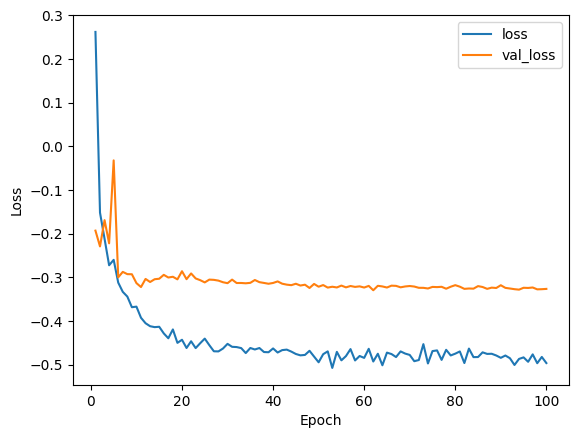

In [17]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["loss"], label="loss")
plt.plot(x, tr.history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(os.path.join(tr.log_path, "loss.png"), bbox_inches="tight")

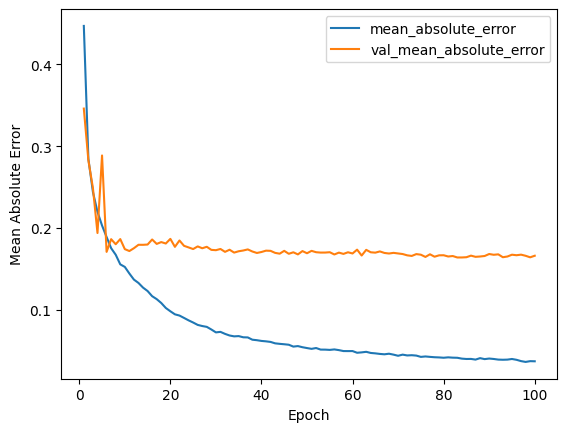

In [18]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["mean_absolute_error"], label="mean_absolute_error")
plt.plot(
    x, tr.history.history["val_mean_absolute_error"], label="val_mean_absolute_error"
)
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend(loc="upper right")
plt.savefig(os.path.join(tr.log_path, "error.png"), bbox_inches="tight")

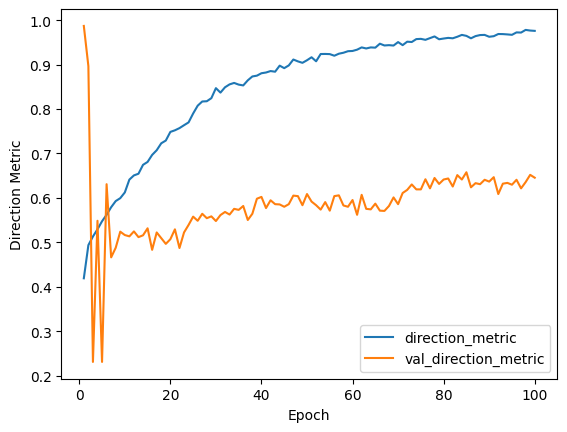

In [19]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["direction_metric"], label="direction_metric")
plt.plot(x, tr.history.history["val_direction_metric"], label="val_direction_metric")
plt.xlabel("Epoch")
plt.ylabel("Direction Metric")
plt.legend(loc="lower right")
plt.savefig(os.path.join(tr.log_path, "direction.png"), bbox_inches="tight")

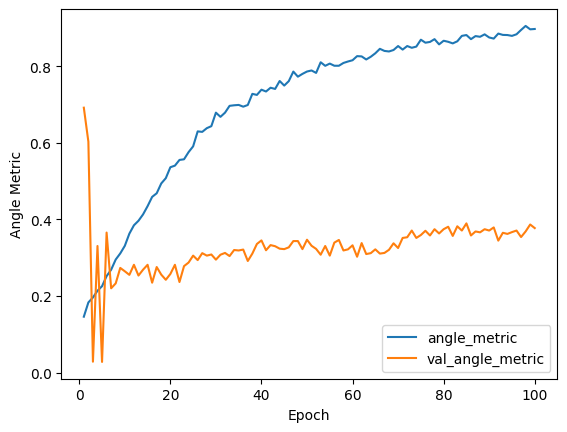

In [20]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["angle_metric"], label="angle_metric")
plt.plot(x, tr.history.history["val_angle_metric"], label="val_angle_metric")
plt.xlabel("Epoch")
plt.ylabel("Angle Metric")
plt.legend(loc="lower right")
plt.savefig(os.path.join(tr.log_path, "angle.png"), bbox_inches="tight")

### Save tf lite models for best train, best val and last checkpoint

In [21]:
best_train_checkpoint = "cp-best-train.ckpt"
best_train_tflite = utils.generate_tflite(tr.checkpoint_path, best_train_checkpoint)
utils.save_tflite(best_train_tflite, tr.checkpoint_path, "best-train")
best_train_index = np.argmin(np.array(tr.history.history["loss"]))
print(
    "Best Train Checkpoint (epoch %s) - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        best_train_index,
        tr.history.history["angle_metric"][best_train_index],
        tr.history.history["val_angle_metric"][best_train_index],
        tr.history.history["direction_metric"][best_train_index],
        tr.history.history["val_direction_metric"][best_train_index],
    )
)

Best Train Checkpoint (epoch 52) - angle: 0.8101, val_angle: 0.3078, direction: 0.9239, val_direction: 0.5736


In [22]:
best_val_checkpoint = "cp-best-val.ckpt"
best_val_tflite = utils.generate_tflite(tr.checkpoint_path, best_val_checkpoint)
utils.save_tflite(best_val_tflite, tr.checkpoint_path, "best")
utils.save_tflite(best_val_tflite, tr.checkpoint_path, "best-val")
best_val_index = np.argmin(np.array(tr.history.history["val_loss"]))
print(
    "Best Val Checkpoint (epoch %s) - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        best_val_index,
        tr.history.history["angle_metric"][best_val_index],
        tr.history.history["val_angle_metric"][best_val_index],
        tr.history.history["direction_metric"][best_val_index],
        tr.history.history["val_direction_metric"][best_val_index],
    )
)

Best Val Checkpoint (epoch 61) - angle: 0.8254, val_angle: 0.3382, direction: 0.9388, val_direction: 0.6069


In [23]:
last_checkpoint = "cp-last.ckpt"
last_tflite = utils.generate_tflite(tr.checkpoint_path, last_checkpoint)
utils.save_tflite(last_tflite, tr.checkpoint_path, "last")
print(
    "Last Checkpoint - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        tr.history.history["angle_metric"][-1],
        tr.history.history["val_angle_metric"][-1],
        tr.history.history["direction_metric"][-1],
        tr.history.history["val_direction_metric"][-1],
    )
)

Last Checkpoint - angle: 0.8970, val_angle: 0.3773, direction: 0.9760, val_direction: 0.6454


### Evaluate the best model (train loss) on the training set

In [24]:
best_train_model = utils.load_model(
    os.path.join(tr.checkpoint_path, best_train_checkpoint),
    tr.loss_fn,
    tr.metric_list,
    tr.custom_objects,
)
loss, mae, direction, angle = best_train_model.evaluate(
    tr.train_ds,
    steps=tr.image_count_train / tr.hyperparameters.TRAIN_BATCH_SIZE,
    verbose=1,
)

42/42 [==============================] - 2s 22ms/step - loss: -0.4826 - mean_absolute_error: 0.0490 - direction_metric: 0.9275 - angle_metric: 0.8216


1/1 [==============================] - 0s 204ms/step


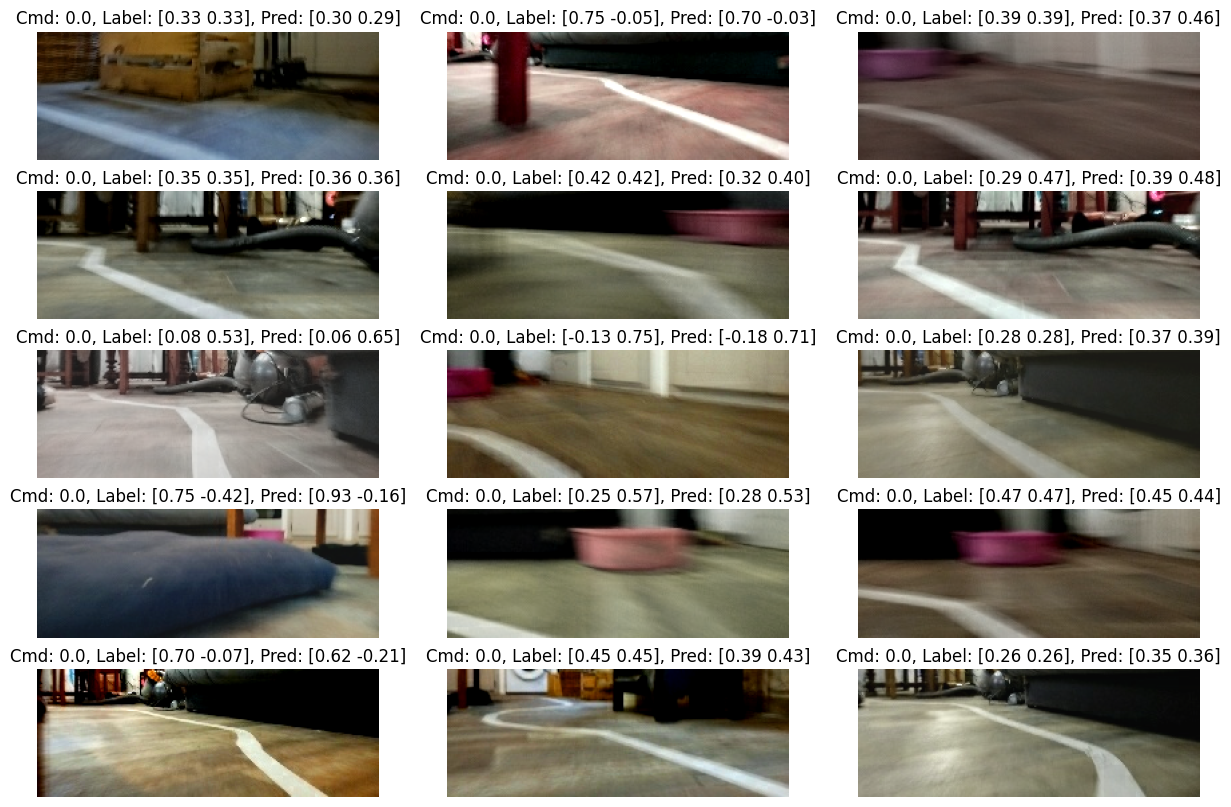

In [25]:
utils.show_batch(
    dataset=tr.train_ds, policy=tr.hyperparameters.POLICY, model=best_train_model
)

In [26]:
utils.compare_tf_tflite(best_train_model, best_train_tflite)

1/1 [==============================] - 0s 155ms/step
tflite: [[ 0.4087621 -0.1467619]]
tf: [[ 0.41659275 -0.14145866]]
Almost equal (10% tolerance): True


### Evaluate the best model (val loss) on the validation set

In [27]:
best_val_model = utils.load_model(
    os.path.join(tr.checkpoint_path, best_val_checkpoint),
    tr.loss_fn,
    tr.metric_list,
    tr.custom_objects,
)
loss, mae, direction, angle = best_val_model.evaluate(
    tr.test_ds,
    steps=tr.image_count_test / tr.hyperparameters.TEST_BATCH_SIZE,
    verbose=1,
)

107/107 [==============================] - 1s 4ms/step - loss: -0.3297 - mean_absolute_error: 0.1664 - direction_metric: 0.6069 - angle_metric: 0.3382


1/1 [==============================] - 0s 136ms/step


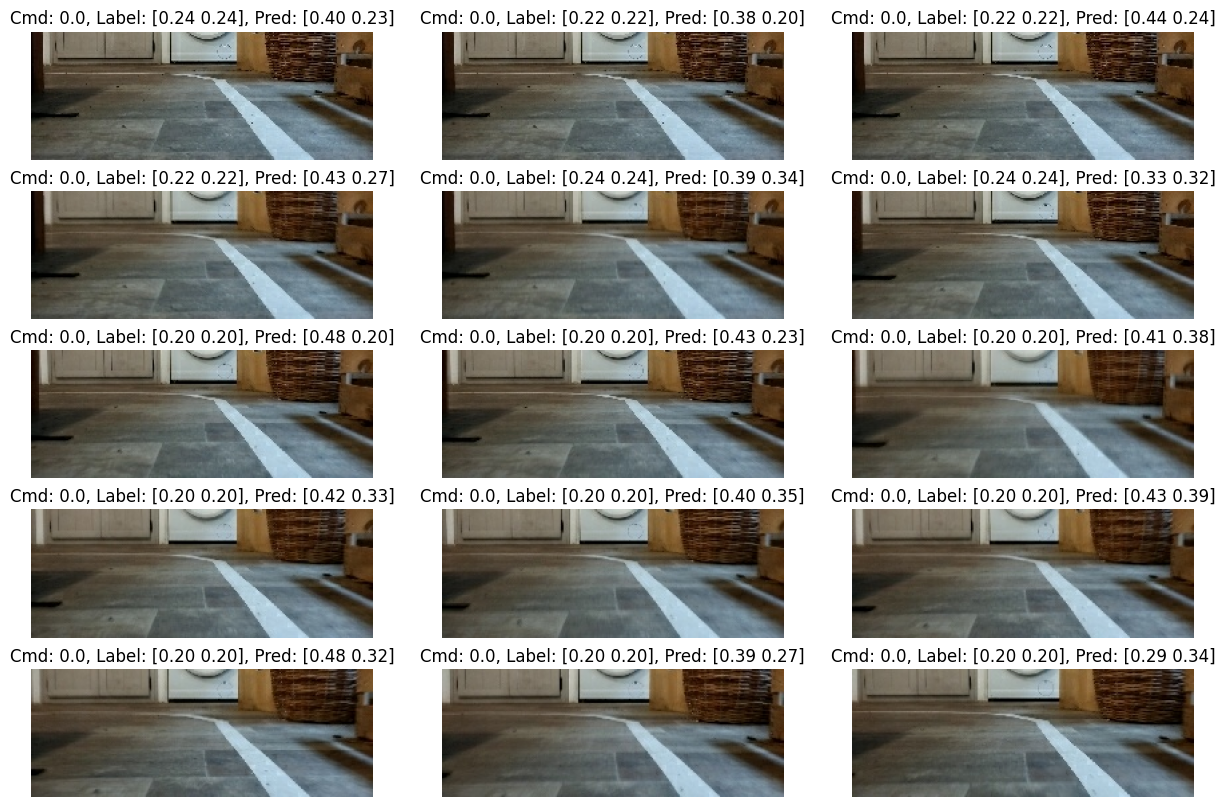

In [28]:
utils.show_batch(
    dataset=tr.test_ds, policy=tr.hyperparameters.POLICY, model=best_val_model
)

In [29]:
utils.compare_tf_tflite(best_val_model, best_val_tflite)

1/1 [==============================] - 0s 101ms/step
tflite: [[0.3706314  0.08669835]]
tf: [[0.36074275 0.0921471 ]]
Almost equal (10% tolerance): True


## Save the notebook as HTML

In [30]:
utils.save_notebook()
current_file = "policy_learning.ipynb"
output_file = os.path.join(tr.log_path, "notebook.html")
utils.output_HTML(current_file, output_file)

In [31]:
model_path = "models/openbot_reinforcement_lr0.0003_bz128_bn/checkpoints/best.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

ValueError: Could not open 'models/openbot_reinforcement_lr0.0003_bz128_bn/checkpoints/best.tflite'.